In [1]:
import matplotlib.pyplot as plt # plotting
#from mpl_toolkits.basemap import Basemap # plotting maps
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sqlite3 # read the database

In [2]:
s = 0
for i in ["property damage only", "pain", "other injury", "severe injury", "fatal"]:

    with sqlite3.connect("switrs.sqlite") as con:
        query = (
                "SELECT collisions.case_id, collisions.collision_severity, collisions.weather_1,collisions.state_highway_indicator, collisions.party_count, collisions.type_of_collision,collisions.lighting, collisions.tow_away, parties.party_age,parties.party_sobriety, collisions.road_surface, collisions.hit_and_run, victims.victim_sex,victims.victim_age,victims.victim_seating_position"
                " FROM collisions INNER JOIN parties ON collisions.case_id = parties.case_id INNER JOIN victims on victims.case_id = collisions.case_id WHERE collisions.collision_severity = '%s' AND parties.at_fault = 1" %(i)
        )
    if s == 0:        
        df = pd.read_sql_query(query, con)
    else:
        df = pd.concat([df, pd.read_sql_query(query, con)], ignore_index = True)
        
    s += 1

In [3]:
df.head()

case_id    collision_severity weather_1  state_highway_indicator  \
0  3495044  property damage only     clear                      1.0   
1  3495044  property damage only     clear                      1.0   
2  3507861  property damage only     clear                      0.0   
3  3511299  property damage only   raining                      0.0   
4  3511306  property damage only    cloudy                      0.0   

   party_count type_of_collision                    lighting  tow_away  \
0          2.0          rear end                    daylight       0.0   
1          2.0          rear end                    daylight       0.0   
2          2.0         broadside                    daylight       1.0   
3          2.0         broadside                    daylight       1.0   
4          2.0         broadside  dark with no street lights       1.0   

   party_age party_sobriety road_surface      hit_and_run victim_sex  \
0       34.0              A          dry  not hit and run       male   
1       34.0              A          dry  not hit and run       male   
2       29.0              B          dry      misdemeanor       male   
3       54.0              A          wet  not hit and run     female   
4       38.0              A          wet  not hit and run       male   

   victim_age victim_seating_position  
0        12.0                       2  
1        21.0                       3  
2        60.0                       9  
3        45.0                       3  
4        42.0                       3

In [4]:
df['collision_severity'].value_counts()

pain                    3873190
property damage only    2451766
other injury            1997187
severe injury            379772
fatal                    133054
Name: collision_severity, dtype: int64

In [5]:
df.to_csv("exploratory_data.csv",index = False)

In [207]:
#df = pd.read_csv("exploratory_data.csv")
df = df.dropna()

# Clean up
df = df[df['road_surface'] != 'H']
df['lighting'].replace('dark with street lights not functioning', 'dark with no street lights',inplace=True)


df['collision_severity'].replace('other injury', 'injury',inplace=True)
df['collision_severity'].replace('pain', 'injury',inplace=True)
df['collision_severity'].replace('severe injury', 'injury',inplace=True)

df = df[df['victim_seating_position'] != 'm']
df = df[df['victim_sex'] != '4']
df = df[df['victim_sex'] != 'X']
df = df[df['victim_sex'] != '2']
df = df[df['victim_sex'] != '1']
df = df[df['victim_sex'] != '3']
df = df[df['victim_sex'] != 'W']
df = df[df['victim_sex'] != 'N']
df = df[df['victim_seating_position'] != 'l']
df = df[df['victim_seating_position'] != 'M']
df = df[df['type_of_collision'] != 'N']
df = df[df['party_count'] <= 6.0]

#df['victim_seating_position'] = df['victim_seating_position'].astype(int)

In [7]:
df.head()

case_id    collision_severity weather_1  state_highway_indicator  \
0  3495044  property damage only     clear                      1.0   
1  3495044  property damage only     clear                      1.0   
2  3507861  property damage only     clear                      0.0   
3  3511299  property damage only   raining                      0.0   
4  3511306  property damage only    cloudy                      0.0   

   party_count type_of_collision                    lighting  tow_away  \
0          2.0          rear end                    daylight       0.0   
1          2.0          rear end                    daylight       0.0   
2          2.0         broadside                    daylight       1.0   
3          2.0         broadside                    daylight       1.0   
4          2.0         broadside  dark with no street lights       1.0   

   party_age party_sobriety road_surface      hit_and_run victim_sex  \
0       34.0              A          dry  not hit and run       male   
1       34.0              A          dry  not hit and run       male   
2       29.0              B          dry      misdemeanor       male   
3       54.0              A          wet  not hit and run     female   
4       38.0              A          wet  not hit and run       male   

   victim_age victim_seating_position  
0        12.0                       2  
1        21.0                       3  
2        60.0                       9  
3        45.0                       3  
4        42.0                       3

In [8]:
df['collision_severity'].value_counts()

injury                  5410538
property damage only    2015933
fatal                    118314
Name: collision_severity, dtype: int64

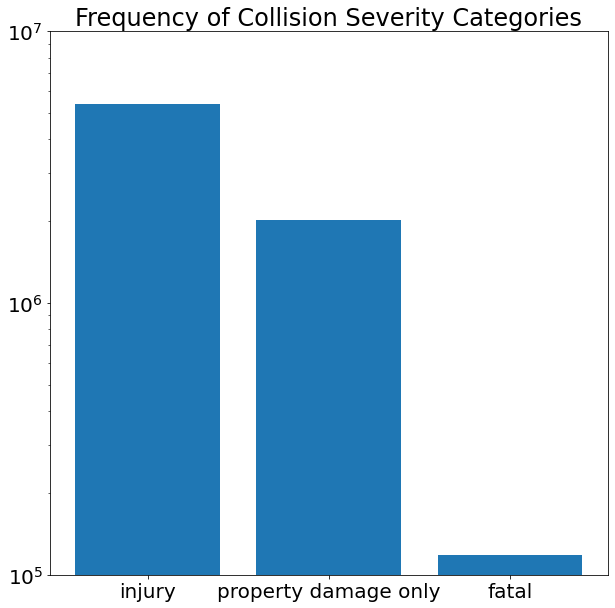

In [17]:
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 20})
cs_labels = list(df['collision_severity'].value_counts().index.tolist())
cs_freqs = list(df['collision_severity'].value_counts())
plt.title('Frequency of Collision Severity Categories', fontsize=24)
plt.ylim(10**5, 10**7)
plt.bar(cs_labels, cs_freqs)
plt.yscale('log')
plt.savefig('cs_label_bar.png')
plt.show()

In [18]:
df['party_age'].mean()

36.1630027893439

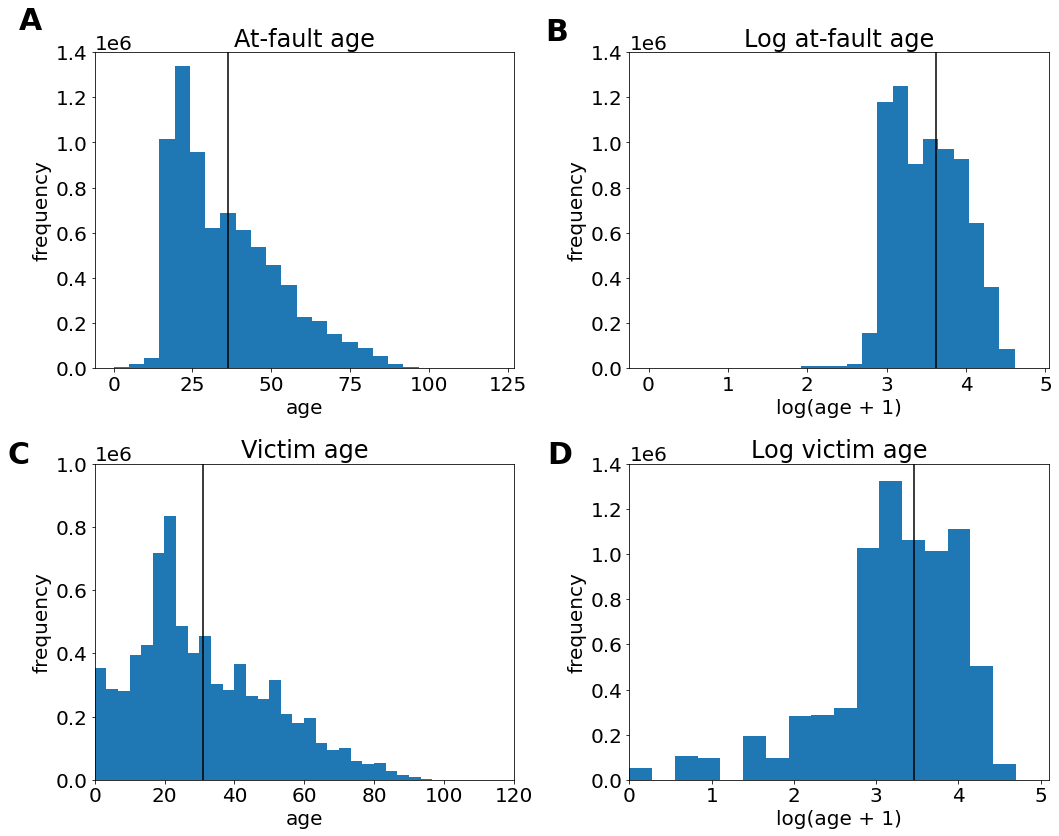

In [178]:
fig, ax = plt.subplots(2, 2, figsize=(15,12))

ax[0,0].hist(df['party_age'], bins=25)
ax[0,0].vlines(df['party_age'].mean(), 0, 1.40e6)
ax[0,0].set_ylim(0, 1.40e6)
ax[0,0].set_title('At-fault age', fontsize=24)
ax[0,0].set_ylabel('frequency')
ax[0,0].set_xlabel('age')
ax[0,0].text(-30, 1500000, 'A', size=30, weight='bold')

ax[0,1].hist(np.log(np.asarray(df['party_age']) + 1), bins=25)
ax[0,1].vlines(np.log(df['party_age'].mean()+1), 0, 1.40e6)
ax[0,1].set_ylim(0, 1.40e6)
ax[0,1].set_title('Log at-fault age')
ax[0,1].set_ylabel('frequency')
ax[0,1].set_xlabel('log(age + 1)')
ax[0,1].text(-1.3, 1450000, 'B', size=30, weight='bold')

ax[1,0].hist(df['victim_age'], bins=300)
ax[1,0].set_xlim(0,120)
ax[1,0].vlines(df['victim_age'].mean(), 0, 1.00e6)
ax[1,0].set_ylim(0, 1.00e6)
ax[1,0].set_title('Victim age')
ax[1,0].set_ylabel('frequency')
ax[1,0].set_xlabel('age')
ax[1,0].text(-25, 1000000, 'C', size=30, weight='bold')

ax[1,1].hist(np.log(np.asarray(df['victim_age']) + 1), bins=25)
ax[1,1].vlines(np.log(df['victim_age'].mean()+1), 0, 1.40e6)
ax[1,1].set_xlim(0,5.1)
ax[1,1].set_ylim(0, 1.40e6)
ax[1,1].set_title('Log victim age')
ax[1,1].set_ylabel('frequency')
ax[1,1].set_xlabel('log(age + 1)')
ax[1,1].text(-1, 1400000, 'D', size=30, weight='bold')


plt.savefig('ages.png')

plt.tight_layout()
plt.show()

In [41]:
def pie_chart(df, cs_label, feat, colors):
    spec_df = df.loc[df['collision_severity'] == cs_label][feat]
    labs = list(spec_df.value_counts().index.tolist())
    freqs = list(spec_df.value_counts())
    
    # plotting
    fig, ax = plt.subplots(figsize=(10,10))
    ax.pie(freqs, labels=labs, autopct='%1.1f%%', colors=colors, pctdistance=0.85)
    
    #draw circle
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    
    ax.axis('equal') 
    plt.tight_layout()
    plt.show()
    
    #print(labs)
    
    print("Most common '{0}' for severity level of '{1}' is '{2}'".format(feat, cs_label, labs[freqs.index(max(freqs))]))
    
    return labs[freqs.index(max(freqs))]
    
    

In [42]:
cs_labels = list(df['collision_severity'].unique())
print(cs_labels)

cs_counts = list(df['collision_severity'].value_counts())
cs_counts[0], cs_counts[1] = cs_counts[1], cs_counts[0]

['property damage only', 'injury', 'fatal']


# type_of_collision

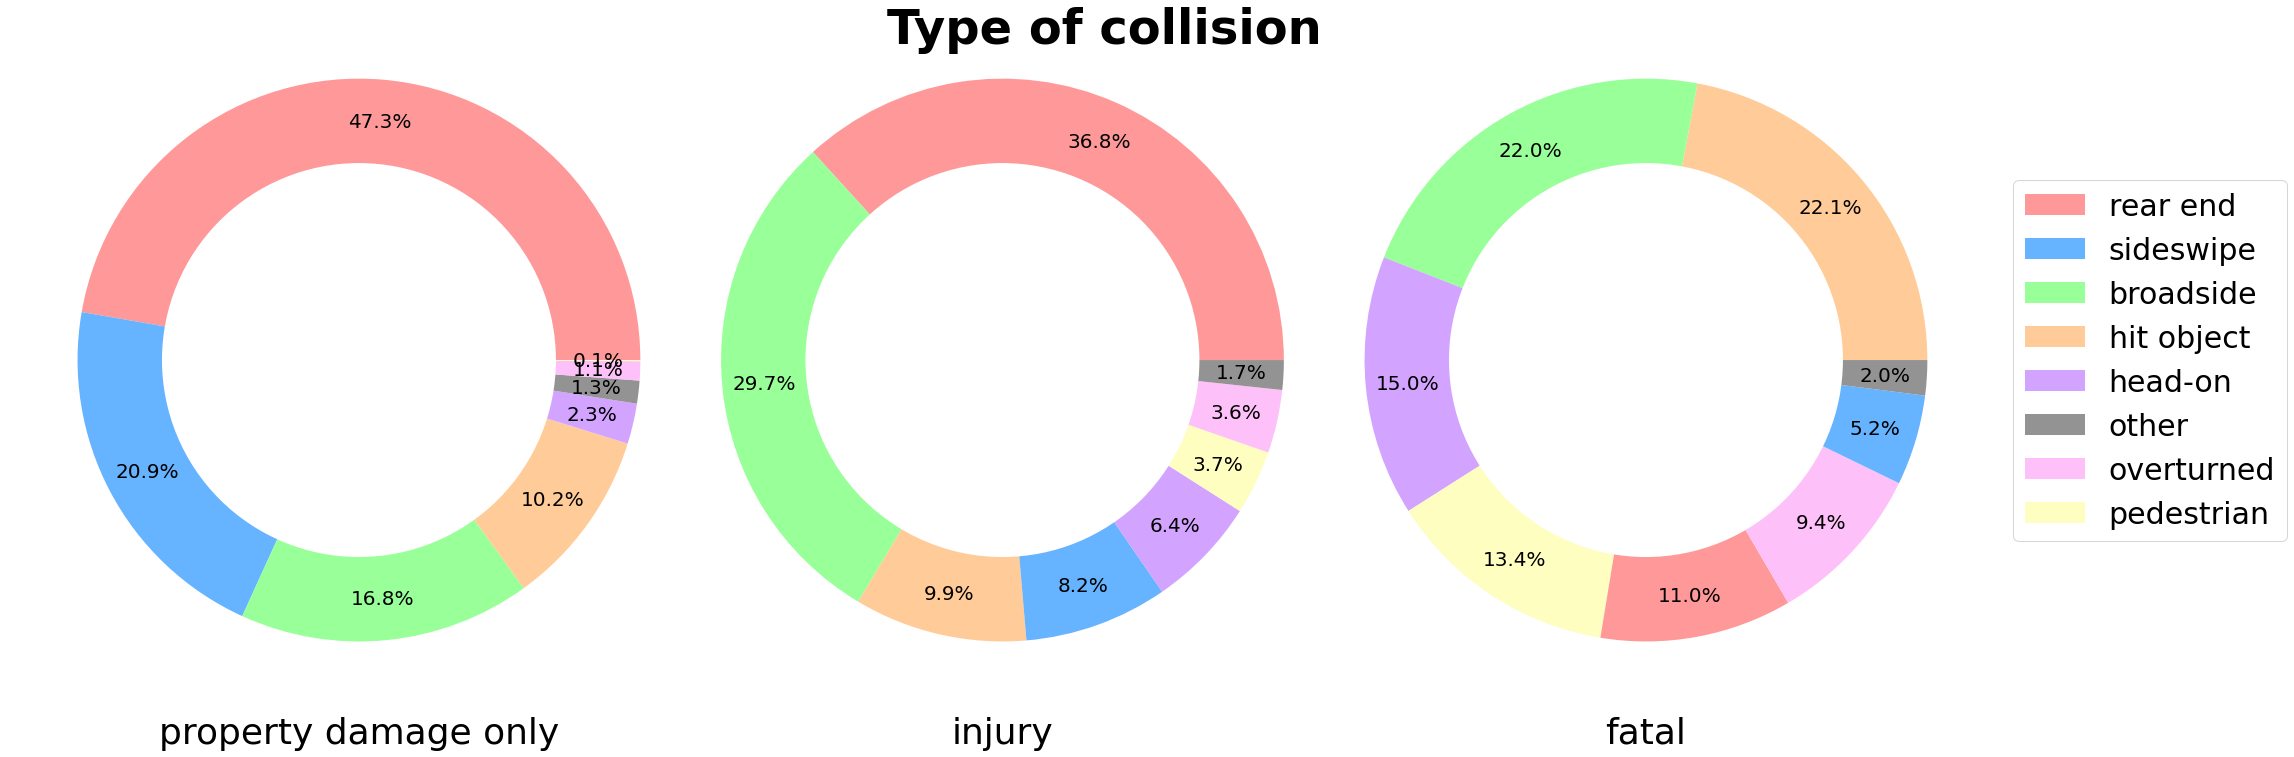

In [194]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))

feat = 'type_of_collision'

colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#D3A4FF', '#939393', '#FEC0F8', '#FEFEC0']
spec_df = df.loc[df['collision_severity'] == cs_labels[0]][feat]
labs1 = list(spec_df.value_counts().index.tolist())
freqs = list(spec_df.value_counts())
wedges, texts, autotexts = ax[0].pie(freqs, autopct='%1.1f%%', colors=colors, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
ax[0].add_artist(centre_circle)
ax[0].set_xlabel(cs_labels[0], fontsize=36)


colors = ['#ff9999','#99ff99', '#ffcc99', '#66b3ff', '#D3A4FF', '#FEFEC0', '#FEC0F8', '#939393']
spec_df = df.loc[df['collision_severity'] == cs_labels[1]][feat]
labs = list(spec_df.value_counts().index.tolist())
freqs = list(spec_df.value_counts())
ax[1].pie(freqs, autopct='%1.1f%%', colors=colors, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
ax[1].add_artist(centre_circle)
ax[1].set_xlabel(cs_labels[1], fontsize=36)

colors = ['#ffcc99', '#99ff99', '#D3A4FF', '#FEFEC0', '#ff9999', '#FEC0F8', '#66b3ff', '#939393']
spec_df = df.loc[df['collision_severity'] == cs_labels[2]][feat]
labs = list(spec_df.value_counts().index.tolist())
freqs = list(spec_df.value_counts())
ax[2].pie(freqs, autopct='%1.1f%%', colors=colors, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
ax[2].add_artist(centre_circle)
ax[2].set_xlabel(cs_labels[2], fontsize=36)

lgd = ax[2].legend(wedges, labs1,
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1),
          prop={'size': 30})


fig.suptitle('Type of collision', fontsize=48, fontweight="bold", x = 0.48, y=1)
plt.tight_layout(pad=-3.0)

plt.savefig('{0}.png'.format(feat), bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [91]:
cs_counts = list(df['collision_severity'].value_counts())
cs_counts[0], cs_counts[1] = cs_counts[1], cs_counts[0]

[5410538, 2015933, 118314]
[2015933, 5410538, 118314]


[[47.27116427 20.92222311 16.76102331 10.24741398  2.31862864  1.314379
   1.10013577  0.06503192]
 [36.76072509 29.67490479  9.92498343  8.24369037  6.382101    3.68442103
   3.63069255  1.69848174]
 [22.07262032 21.98302821 14.95427422 13.40078097 11.02489984  9.35730345
   5.18788985  2.01920314]]


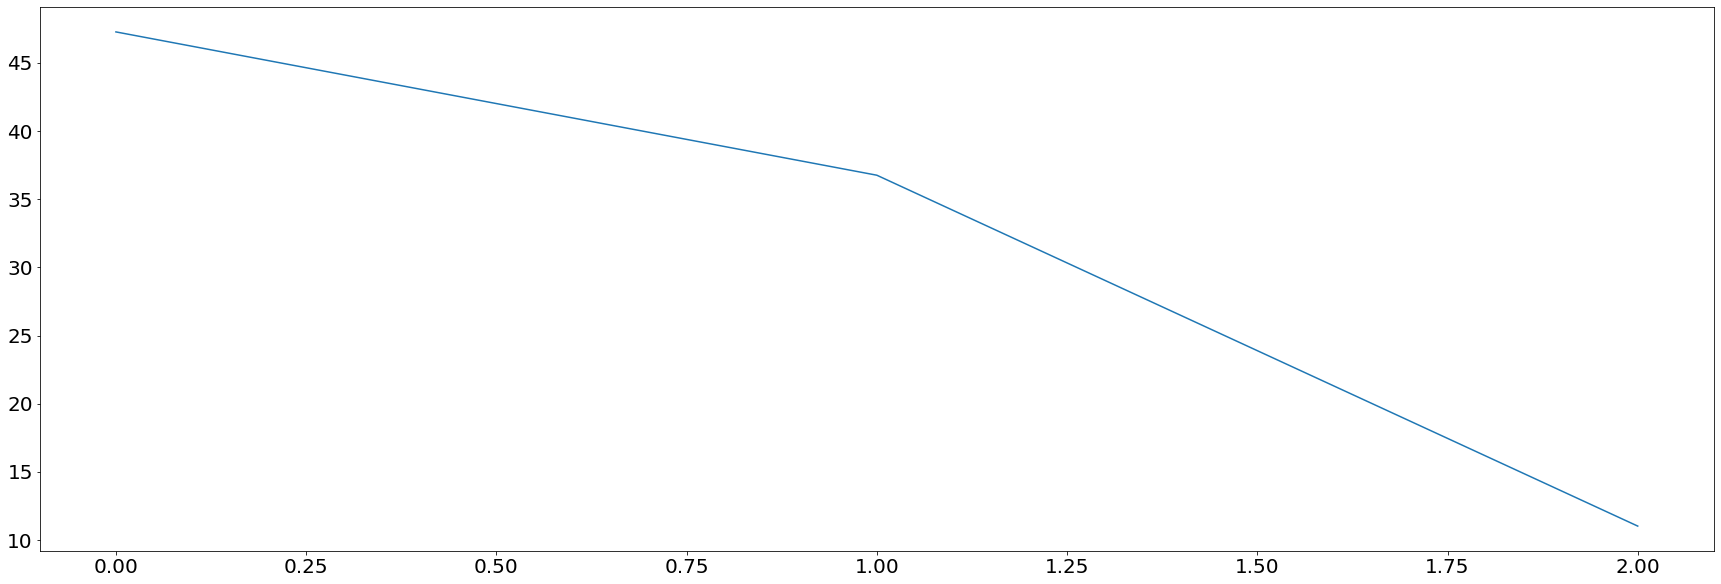

In [100]:
plt.figure(figsize=(30,10))

feat = 'type_of_collision'

feat_change_sev = np.zeros((3, 8))

for j in range(len(cs_labels)):
    spec_df = df.loc[df['collision_severity'] == cs_labels[j]][feat]
    labs = list(spec_df.value_counts().index.tolist())
    freqs = list(spec_df.value_counts())
    prct = [100*freqs[i]/cs_counts[j] for i in range(len(freqs))]
    feat_change_sev[j,:] = prct

print(feat_change_sev)

rear = [feat_change_sev[0,0], feat_change_sev[1,0], feat_change_sev[2,4]]
side = [feat_change_sev[0,1], feat_change_sev[1,3], feat_change_sev[2,6]]
broad = [feat_change_sev[0,2], feat_change_sev[1,1], feat_change_sev[2,1]]
obj = [feat_change_sev[0,3], feat_change_sev[1,2], feat_change_sev[2,0]]
head = [feat_change_sev[0,4], feat_change_sev[1,4], feat_change_sev[2,2]]
other = [feat_change_sev[0,5], feat_change_sev[1,7], feat_change_sev[2,7]]
ot = [feat_change_sev[0,6], feat_change_sev[1,6], feat_change_sev[2,5]]
ped = [feat_change_sev[0,7], feat_change_sev[1,5], feat_change_sev[2,3]]

plt.plot([0,1,2], rear)
#plt.savefig('{0}.png'.format(feat))
plt.show()

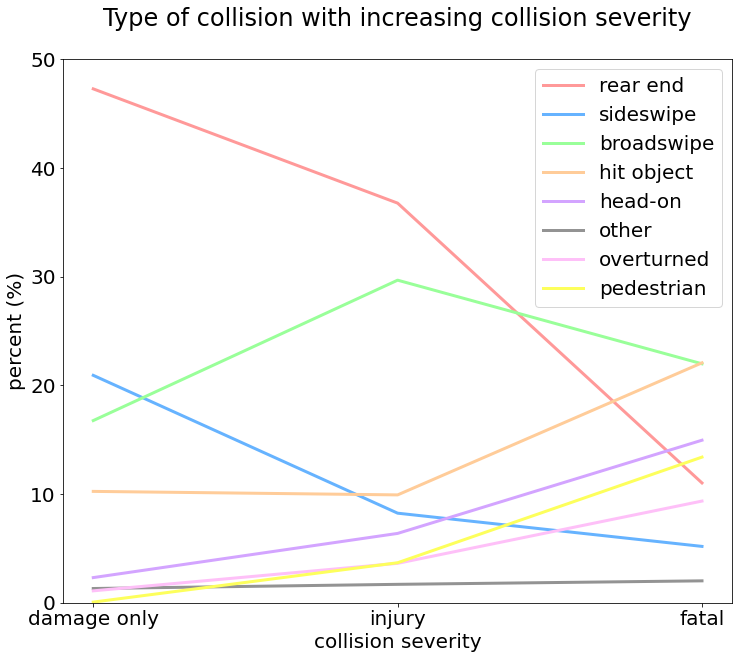

In [190]:
fig = plt.figure(figsize=(12,10))
ax  = fig.add_subplot(111)
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#D3A4FF', '#939393', '#FEC0F8', '#FDFF5C']
lw = 3
ax.plot([0,1,2], rear,  color=colors[0], linewidth=lw, label='rear end')
ax.plot([0,1,2], side,  color=colors[1], linewidth=lw, label='sideswipe')
ax.plot([0,1,2], broad, color=colors[2], linewidth=lw, label='broadswipe')
ax.plot([0,1,2], obj,   color=colors[3], linewidth=lw, label='hit object')
ax.plot([0,1,2], head,  color=colors[4], linewidth=lw, label='head-on')
ax.plot([0,1,2], other, color=colors[5], linewidth=lw, label='other')
ax.plot([0,1,2], ot,    color=colors[6], linewidth=lw, label='overturned')
ax.plot([0,1,2], ped,   color=colors[7], linewidth=lw, label='pedestrian')
ax.set_ylim(0,50)
plt.legend(loc='upper right')
#plt.savefig('{0}.png'.format(feat))
ttl = plt.title('Type of collision with increasing collision severity')
ttl.set_position([.5, 1.05])
plt.xlabel('collision severity')
plt.xticks(np.arange(3), ['damage only', 'injury', 'fatal'])
plt.ylabel('percent (%)')
plt.savefig('type_collision_severity.png', dpi=300)
plt.show()

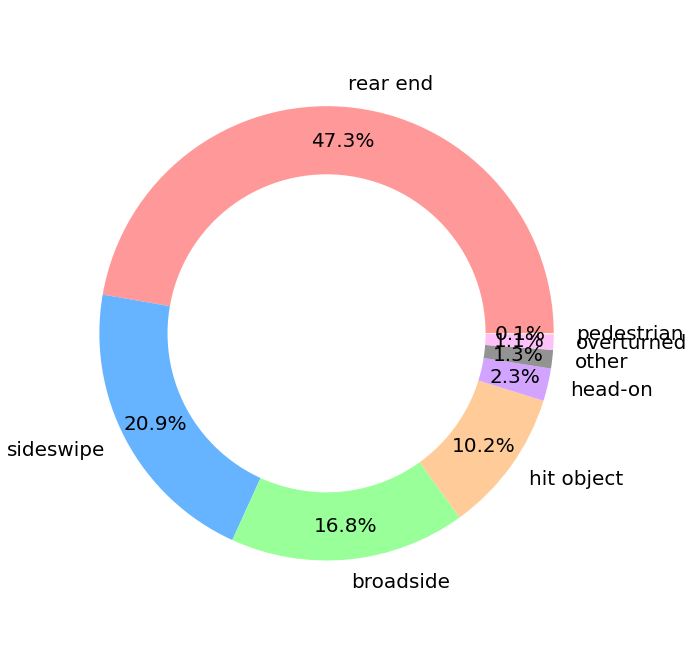

Most common 'type_of_collision' for severity level of 'property damage only' is 'rear end'


In [43]:
max_collision = []
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#D3A4FF', '#939393', '#FEC0F8', '#FEFEC0']
max_collision.append(pie_chart(df, 'property damage only', 'type_of_collision', colors))

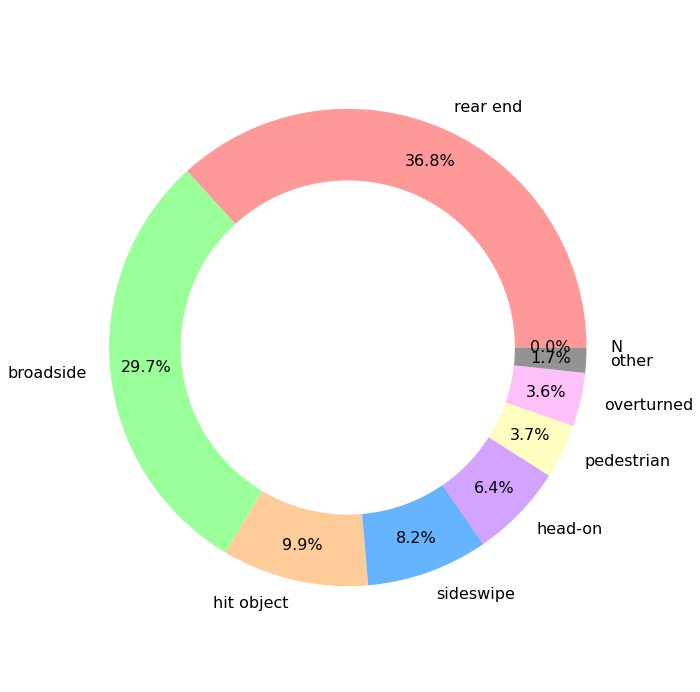

Most common 'type_of_collision' for severity level of 'injury' is 'rear end'


In [203]:
colors = ['#ff9999','#99ff99', '#ffcc99', '#66b3ff', '#D3A4FF', '#FEFEC0', '#FEC0F8', '#939393']
#colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#D3A4FF', '#939393', '#FEC0F8', '#FEFEC0']
max_collision.append(pie_chart(df, 'injury', 'type_of_collision', colors))

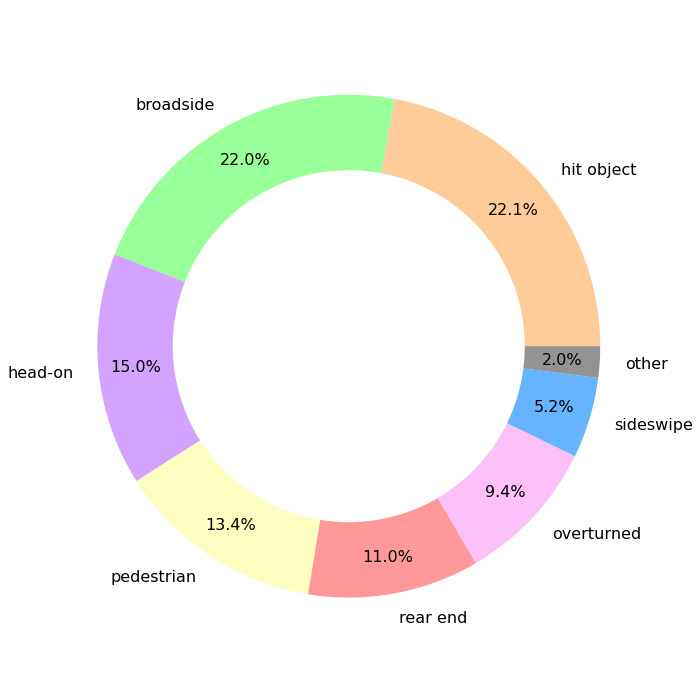

Most common 'type_of_collision' for severity level of 'fatal' is 'hit object'


In [204]:
colors = ['#ffcc99', '#99ff99', '#D3A4FF', '#FEFEC0', '#ff9999', '#FEC0F8', '#66b3ff', '#939393']
max_collision.append(pie_chart(df, 'fatal', 'type_of_collision', colors))

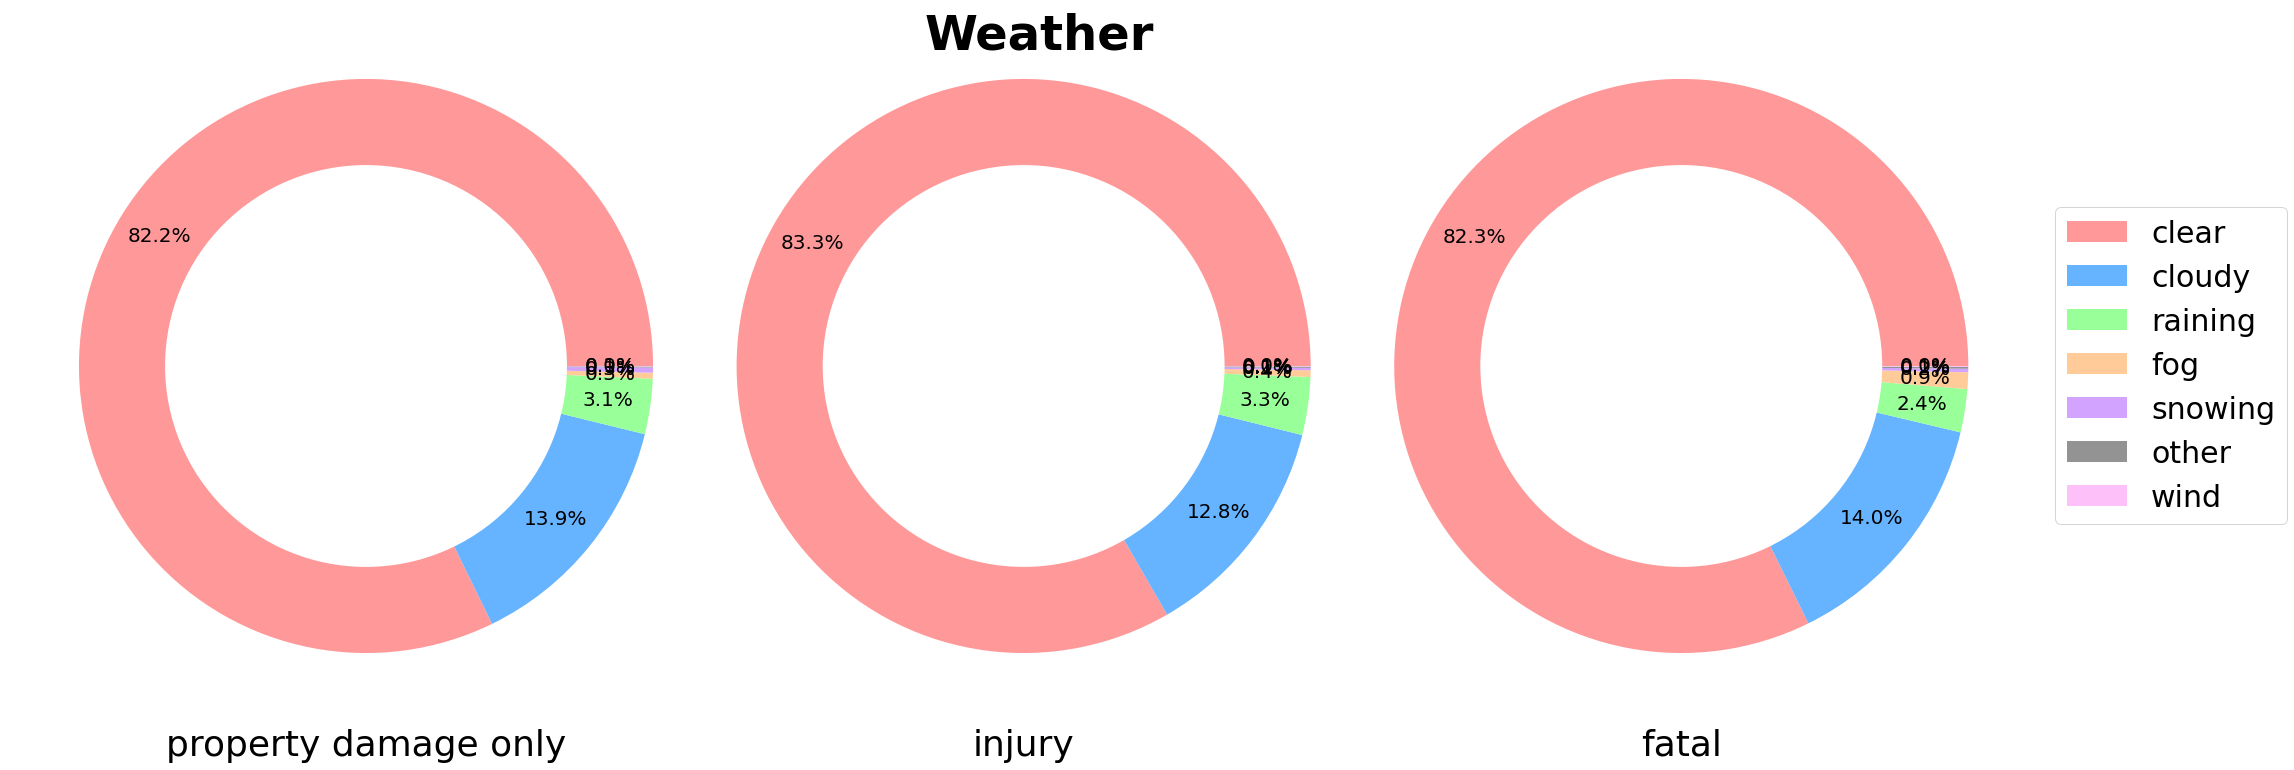

In [244]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))

feat = 'weather_1'

colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#D3A4FF', '#939393', '#FEC0F8', '#FEFEC0']
spec_df = df.loc[df['collision_severity'] == cs_labels[0]][feat]
labs1 = list(spec_df.value_counts().index.tolist())
freqs = list(spec_df.value_counts())
wedges, texts, autotexts = ax[0].pie(freqs, autopct='%1.1f%%', colors=colors, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
ax[0].add_artist(centre_circle)
ax[0].set_xlabel(cs_labels[0], fontsize=36)


spec_df = df.loc[df['collision_severity'] == cs_labels[1]][feat]
labs = list(spec_df.value_counts().index.tolist())
freqs = list(spec_df.value_counts())
ax[1].pie(freqs, autopct='%1.1f%%', colors=colors, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
ax[1].add_artist(centre_circle)
ax[1].set_xlabel(cs_labels[1], fontsize=36)

spec_df = df.loc[df['collision_severity'] == cs_labels[2]][feat]
labs = list(spec_df.value_counts().index.tolist())
freqs = list(spec_df.value_counts())
ax[2].pie(freqs, autopct='%1.1f%%', colors=colors, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
ax[2].add_artist(centre_circle)
ax[2].set_xlabel(cs_labels[2], fontsize=36)

lgd = ax[2].legend(wedges, labs1,
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1),
          prop={'size': 30})


fig.suptitle('Weather', fontsize=48, fontweight="bold", x = 0.45, y=1)
plt.tight_layout(pad=-3.0)

plt.savefig('{0}.png'.format(feat), bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [245]:
plt.figure(figsize=(30,10))

feat = 'weather_1'

feat_change_sev = np.zeros((3, 7))

for j in range(len(cs_labels)):
    spec_df = df.loc[df['collision_severity'] == cs_labels[j]][feat]
    labs = list(spec_df.value_counts().index.tolist())
    freqs = list(spec_df.value_counts())
    print(labs)
    prct = [100*freqs[i]/cs_counts[j] for i in range(len(freqs))]
    feat_change_sev[j,:] = prct
    
clear = [feat_change_sev[0,0], feat_change_sev[1,0], feat_change_sev[2,0]]
cloudy = [feat_change_sev[0,1], feat_change_sev[1,1], feat_change_sev[2,1]]
raining = [feat_change_sev[0,2], feat_change_sev[1,2], feat_change_sev[2,2]]
fog = [feat_change_sev[0,3], feat_change_sev[1,3], feat_change_sev[2,3]]
snowing = [feat_change_sev[0,4], feat_change_sev[1,4], feat_change_sev[2,5]]
wind = [feat_change_sev[0,6], feat_change_sev[1,6], feat_change_sev[2,6]]
other = [feat_change_sev[0,5], feat_change_sev[1,5], feat_change_sev[2,4]]

['clear', 'cloudy', 'raining', 'fog', 'snowing', 'other', 'wind']
['clear', 'cloudy', 'raining', 'fog', 'snowing', 'other', 'wind']
['clear', 'cloudy', 'raining', 'fog', 'other', 'snowing', 'wind']


<Figure size 2160x720 with 0 Axes>

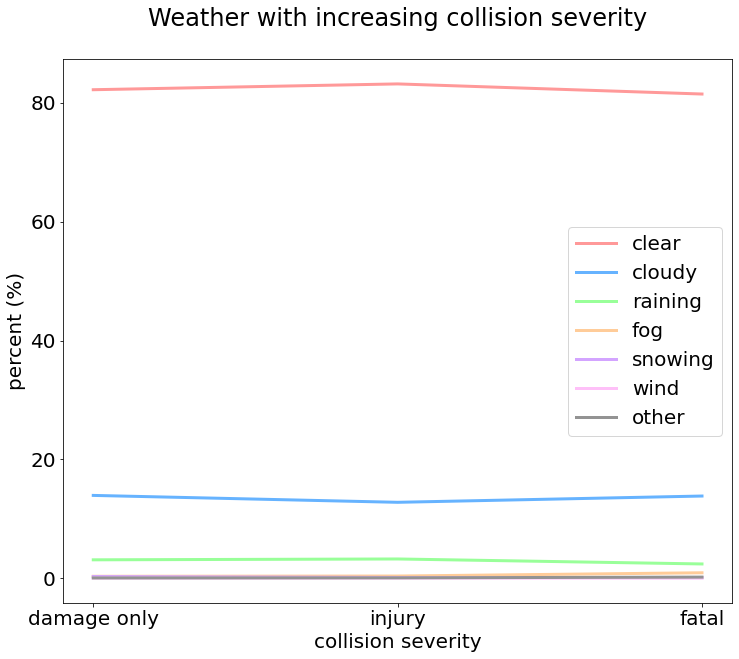

In [247]:
fig = plt.figure(figsize=(12,10))
ax  = fig.add_subplot(111)
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#D3A4FF', '#939393', '#FEC0F8', '#FDFF5C']
lw = 3
ax.plot([0,1,2], clear,  color=colors[0], linewidth=lw, label=labs[0])
ax.plot([0,1,2], cloudy,  color=colors[1], linewidth=lw, label=labs[1])
ax.plot([0,1,2], raining, color=colors[2], linewidth=lw, label=labs[2])
ax.plot([0,1,2], fog,   color=colors[3], linewidth=lw, label=labs[3])
ax.plot([0,1,2], snowing,  color=colors[4], linewidth=lw, label=labs[5])
ax.plot([0,1,2], wind, color=colors[6], linewidth=lw, label=labs[6])
ax.plot([0,1,2], other,    color=colors[5], linewidth=lw, label=labs[4])
#ax.set_ylim(0,15)
plt.legend(loc='center right')
#plt.savefig('{0}.png'.format(feat))
ttl = plt.title('Weather with increasing collision severity')
ttl.set_position([.5, 1.05])
plt.xlabel('collision severity')
plt.xticks(np.arange(3), ['damage only', 'injury', 'fatal'])
plt.ylabel('percent (%)')
plt.savefig('./figs/weather_severity.png', dpi=300)
plt.show()

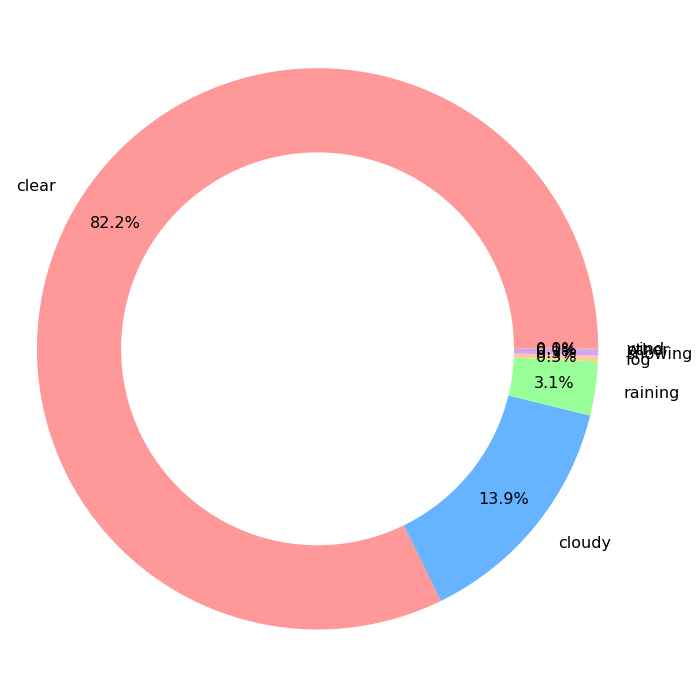

Most common 'weather_1' for severity level of 'property damage only' is 'clear'


'clear'

In [246]:
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#D3A4FF', '#939393', '#FEC0F8', '#FEFEC0']
pie_chart(df, cs_labels[0], 'weather_1', colors)

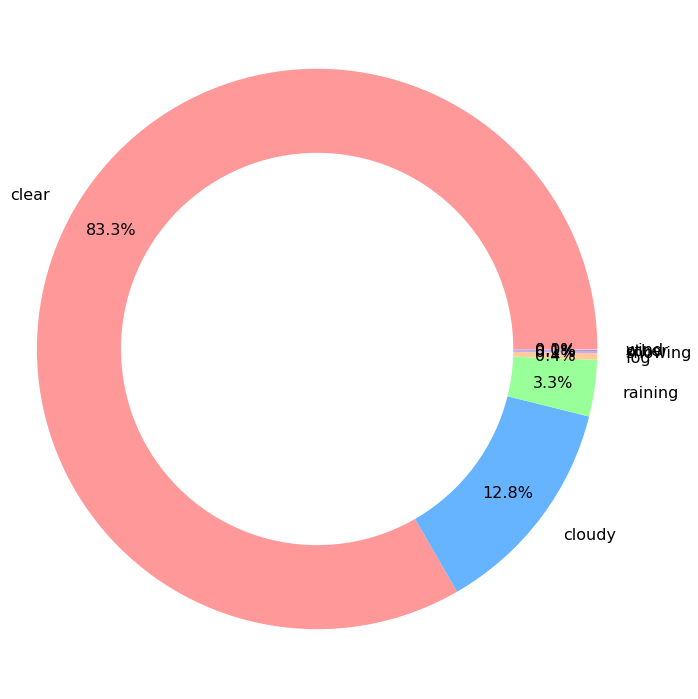

Most common 'weather_1' for severity level of 'injury' is 'clear'


'clear'

In [247]:
pie_chart(df, cs_labels[1], 'weather_1', colors)

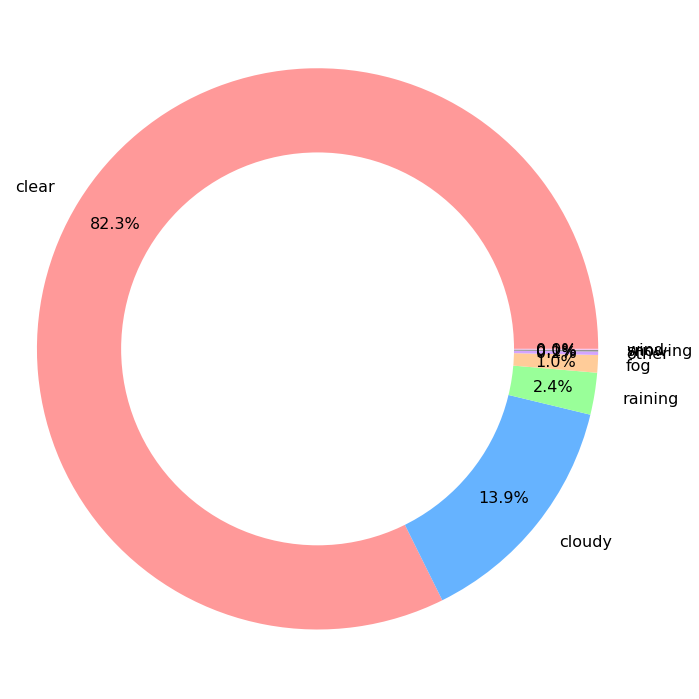

Most common 'weather_1' for severity level of 'fatal' is 'clear'


'clear'

In [248]:
pie_chart(df, cs_labels[2], 'weather_1', colors)

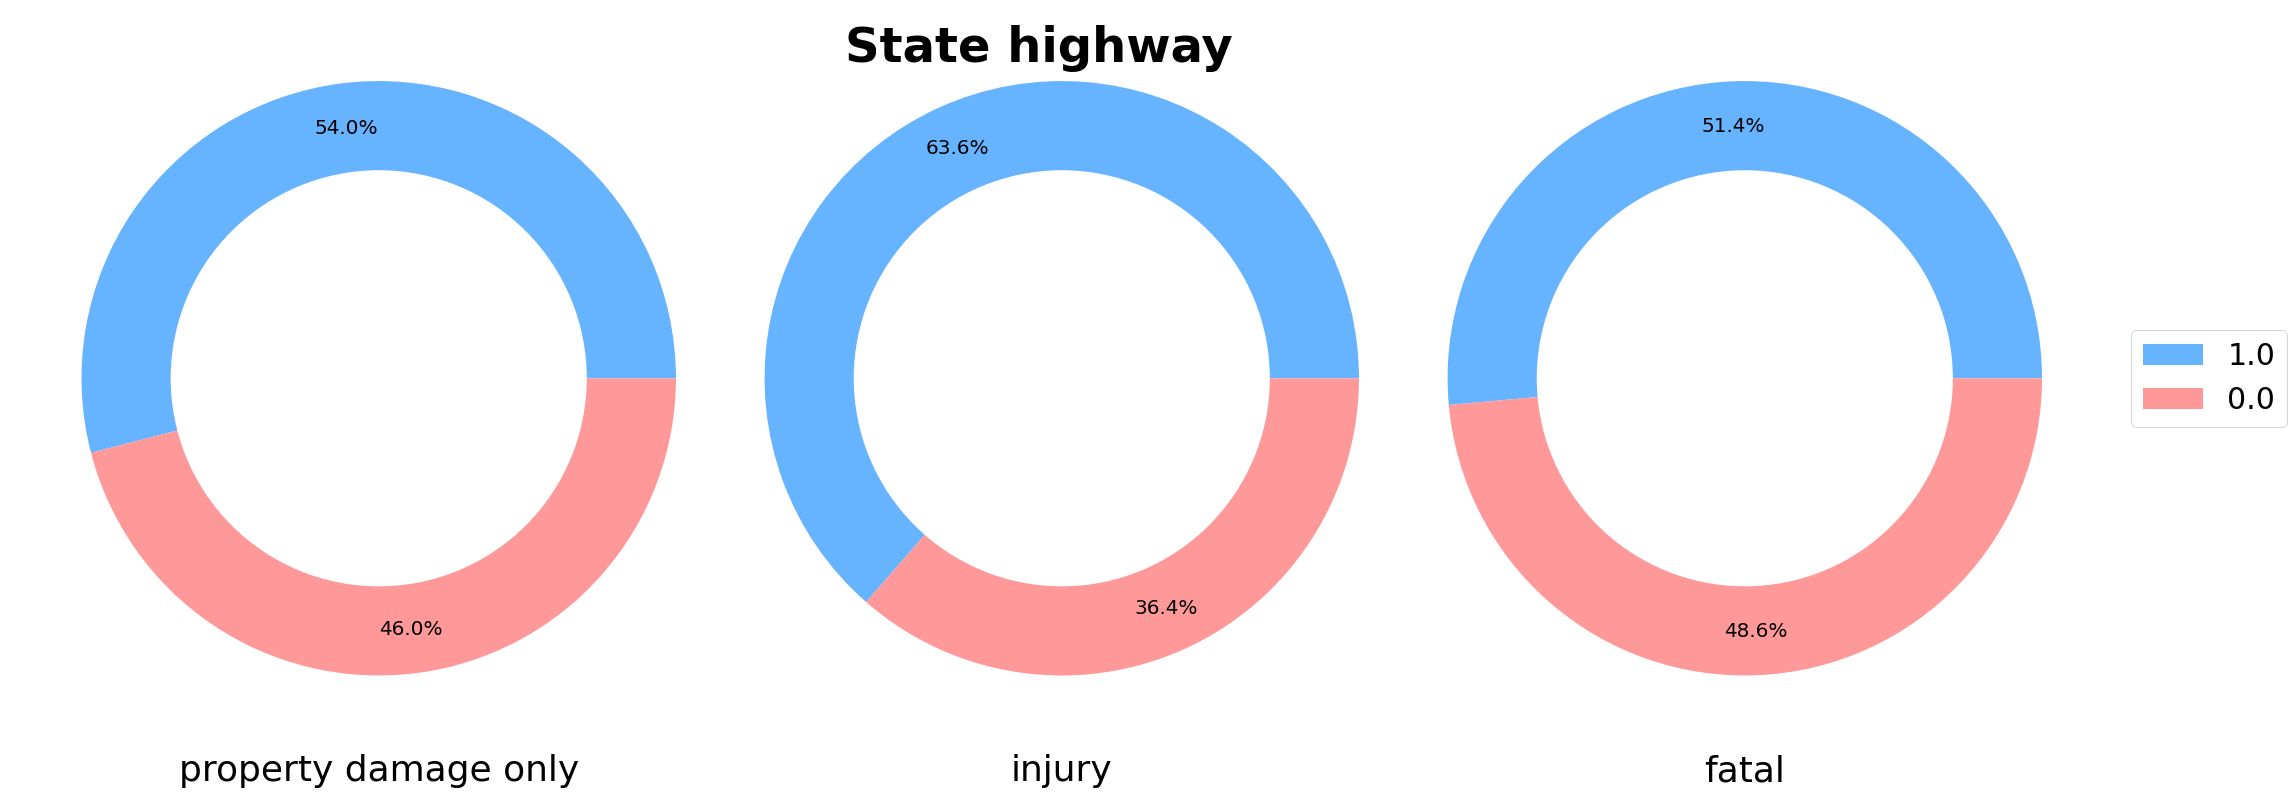

In [205]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))

feat = 'state_highway_indicator'

colors = ['#66b3ff', '#ff9999']
spec_df = df.loc[df['collision_severity'] == cs_labels[0]][feat]
labs1 = list(spec_df.value_counts().index.tolist())
freqs = list(spec_df.value_counts())
wedges, texts, autotexts = ax[0].pie(freqs, autopct='%1.1f%%', colors=colors, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
ax[0].add_artist(centre_circle)
ax[0].set_xlabel(cs_labels[0], fontsize=36)


spec_df = df.loc[df['collision_severity'] == cs_labels[1]][feat]
labs = list(spec_df.value_counts().index.tolist())
freqs = list(spec_df.value_counts())
ax[1].pie(freqs, autopct='%1.1f%%', colors=colors, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
ax[1].add_artist(centre_circle)
ax[1].set_xlabel(cs_labels[1], fontsize=36)

spec_df = df.loc[df['collision_severity'] == cs_labels[2]][feat]
labs = list(spec_df.value_counts().index.tolist())
freqs = list(spec_df.value_counts())
ax[2].pie(freqs, autopct='%1.1f%%', colors=colors, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
ax[2].add_artist(centre_circle)
ax[2].set_xlabel(cs_labels[2], fontsize=36)

lgd = ax[2].legend(wedges, labs1,
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1),
          prop={'size': 30})


fig.suptitle('State highway', fontsize=48, fontweight="bold", x = 0.45, y=1)
plt.tight_layout(pad=-3.0)

plt.savefig('{0}.png'.format(feat), bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

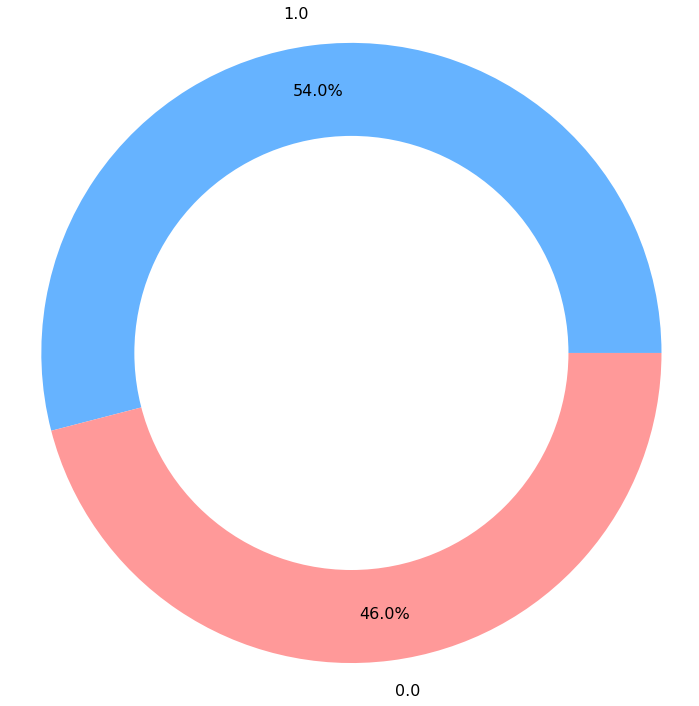

Most common 'state_highway_indicator' for severity level of 'property damage only' is '1.0'


1.0

In [252]:
colors = ['#66b3ff', '#ff9999']
pie_chart(df, cs_labels[0], 'state_highway_indicator', colors)

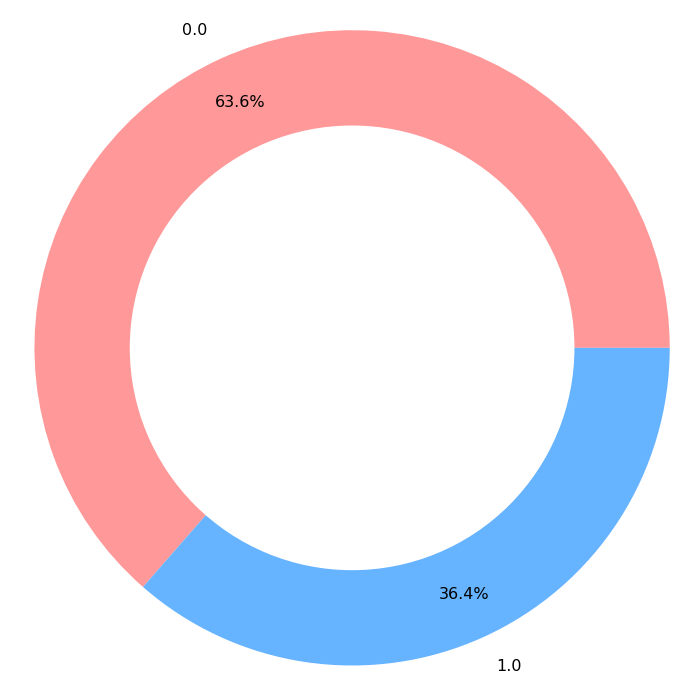

Most common 'state_highway_indicator' for severity level of 'injury' is '0.0'


0.0

In [253]:
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#D3A4FF', '#939393', '#FEC0F8', '#FEFEC0']
pie_chart(df, cs_labels[1], 'state_highway_indicator', colors)

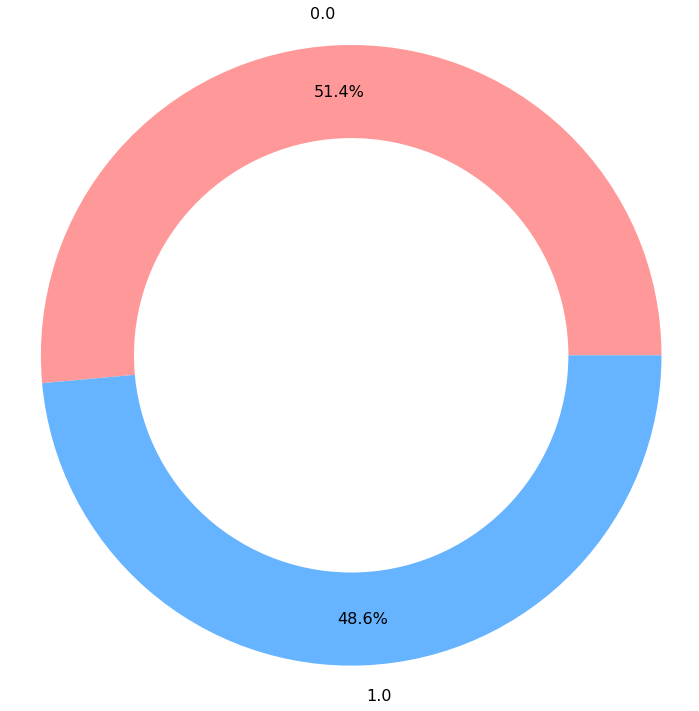

Most common 'state_highway_indicator' for severity level of 'fatal' is '0.0'


0.0

In [254]:
pie_chart(df, cs_labels[2], 'state_highway_indicator', colors)

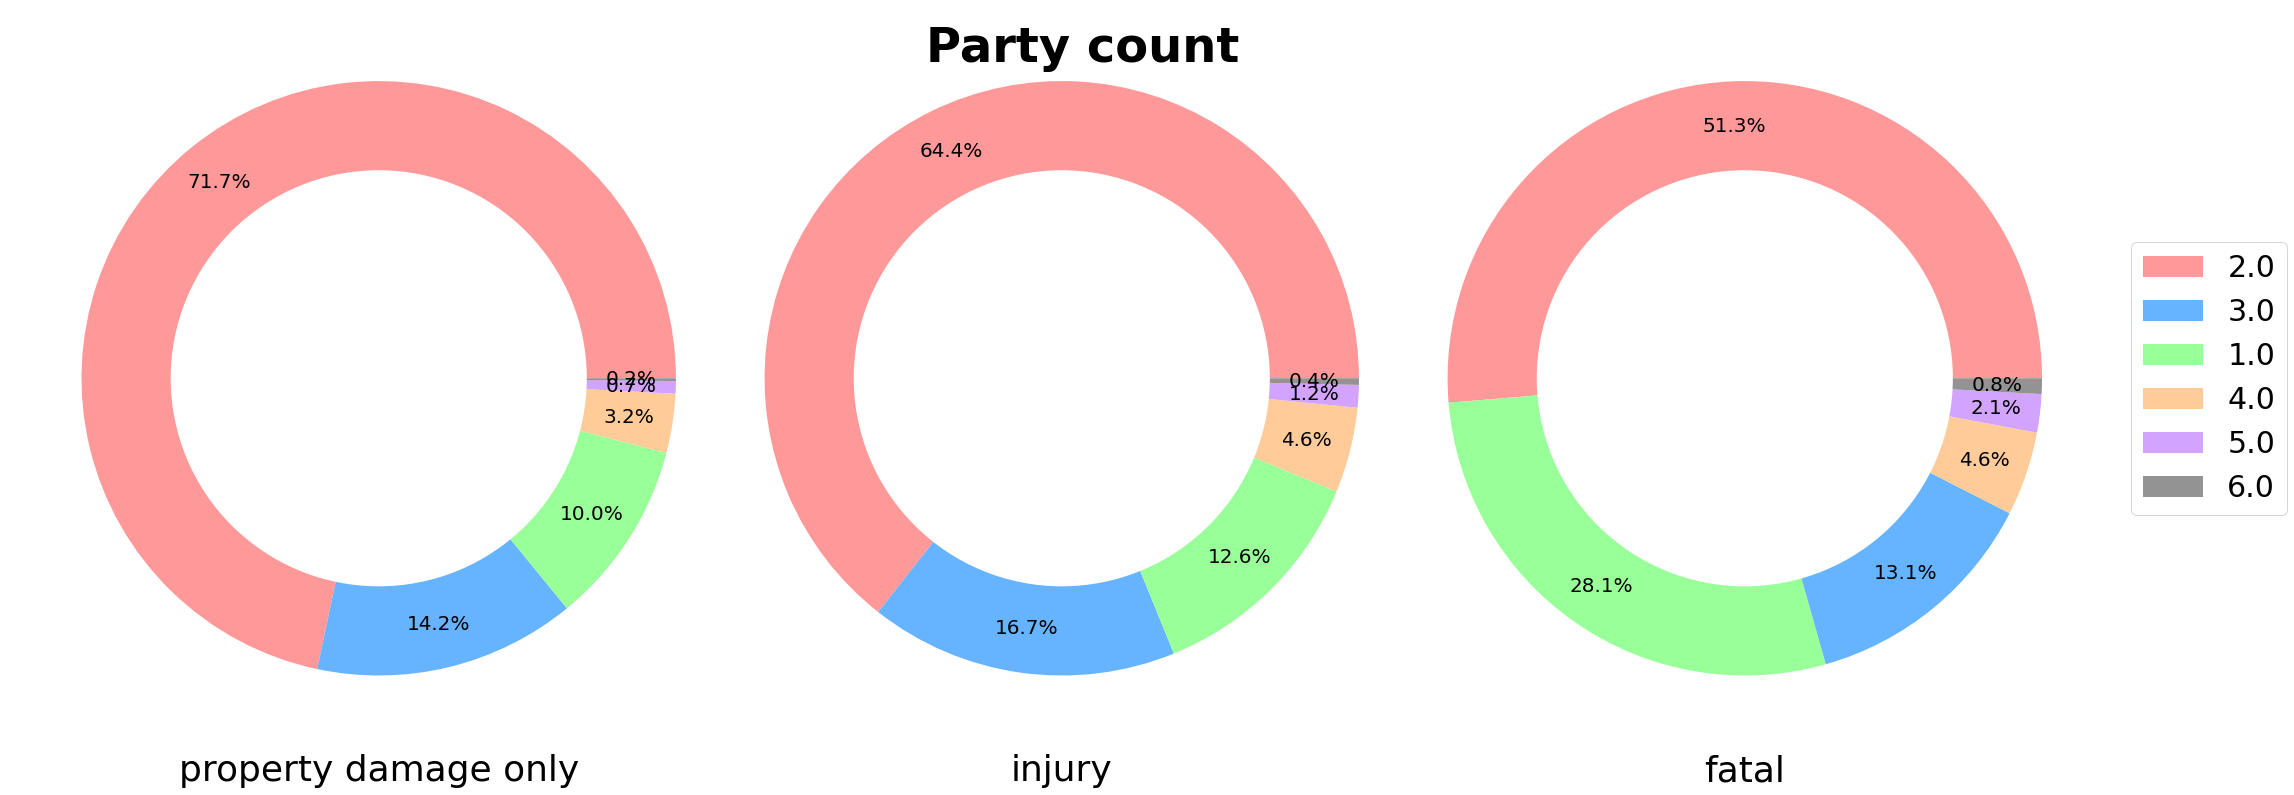

In [214]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))

feat = 'party_count'

colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#D3A4FF', '#939393', '#FEC0F8', '#FEFEC0']
spec_df = df.loc[df['collision_severity'] == cs_labels[0]][feat]
labs1 = list(spec_df.value_counts().index.tolist())
freqs = list(spec_df.value_counts())
wedges, texts, autotexts = ax[0].pie(freqs, autopct='%1.1f%%', colors=colors, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
ax[0].add_artist(centre_circle)
ax[0].set_xlabel(cs_labels[0], fontsize=36)


spec_df = df.loc[df['collision_severity'] == cs_labels[1]][feat]
labs = list(spec_df.value_counts().index.tolist())
freqs = list(spec_df.value_counts())
ax[1].pie(freqs, autopct='%1.1f%%', colors=colors, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
ax[1].add_artist(centre_circle)
ax[1].set_xlabel(cs_labels[1], fontsize=36)

colors = ['#ff9999','#99ff99','#66b3ff', '#ffcc99', '#D3A4FF', '#939393', '#FEC0F8', '#FEFEC0']
spec_df = df.loc[df['collision_severity'] == cs_labels[2]][feat]
labs = list(spec_df.value_counts().index.tolist())
freqs = list(spec_df.value_counts())
ax[2].pie(freqs, autopct='%1.1f%%', colors=colors, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
ax[2].add_artist(centre_circle)
ax[2].set_xlabel(cs_labels[2], fontsize=36)

lgd = ax[2].legend(wedges, labs1,
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1),
          prop={'size': 30})


fig.suptitle('Party count', fontsize=48, fontweight="bold", x = 0.47, y=1)
plt.tight_layout(pad=-3.0)

plt.savefig('{0}.png'.format(feat), bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [211]:
plt.figure(figsize=(30,10))

feat = 'party_count'

feat_change_sev = np.zeros((3, 6))

for j in range(len(cs_labels)):
    spec_df = df.loc[df['collision_severity'] == cs_labels[j]][feat]
    labs = list(spec_df.value_counts().index.tolist())
    freqs = list(spec_df.value_counts())
    print(labs)
    prct = [100*freqs[i]/cs_counts[j] for i in range(len(freqs))]
    feat_change_sev[j,:] = prct

[2.0, 3.0, 1.0, 4.0, 5.0, 6.0]
[2.0, 3.0, 1.0, 4.0, 5.0, 6.0]
[2.0, 1.0, 3.0, 4.0, 5.0, 6.0]


<Figure size 2160x720 with 0 Axes>

In [213]:
two = [feat_change_sev[0,0], feat_change_sev[1,0], feat_change_sev[2,0]]
three = [feat_change_sev[0,1], feat_change_sev[1,1], feat_change_sev[2,2]]
one = [feat_change_sev[0,2], feat_change_sev[1,2], feat_change_sev[2,1]]
four = [feat_change_sev[0,3], feat_change_sev[1,3], feat_change_sev[2,3]]
five = [feat_change_sev[0,4], feat_change_sev[1,4], feat_change_sev[2,4]]
six = [feat_change_sev[0,5], feat_change_sev[1,5], feat_change_sev[2,5]]

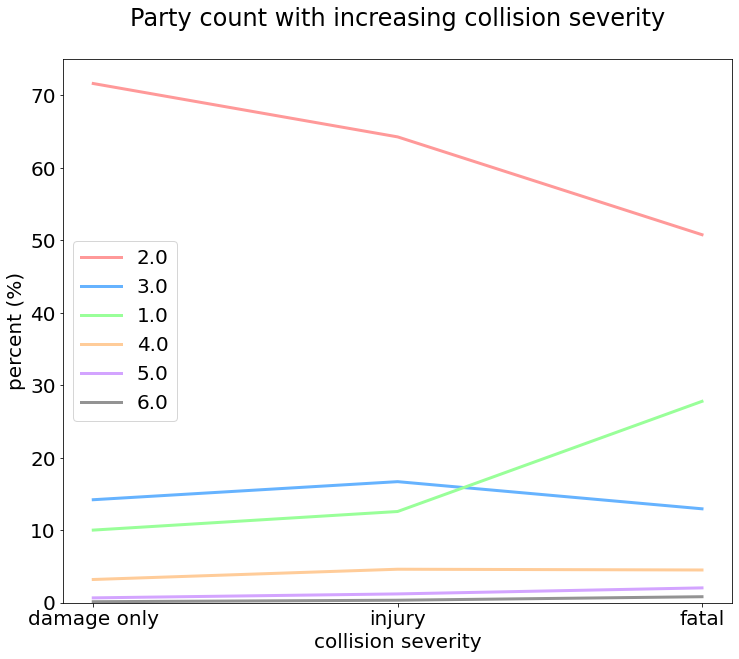

In [216]:
fig = plt.figure(figsize=(12,10))
ax  = fig.add_subplot(111)
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#D3A4FF', '#939393', '#FEC0F8', '#FDFF5C']
lw = 3
ax.plot([0,1,2], two,  color=colors[0], linewidth=lw, label=labs[0])
ax.plot([0,1,2], three,  color=colors[1], linewidth=lw, label=labs[2])
ax.plot([0,1,2], one, color=colors[2], linewidth=lw, label=labs[1])
ax.plot([0,1,2], four,   color=colors[3], linewidth=lw, label=labs[3])
ax.plot([0,1,2], five,  color=colors[4], linewidth=lw, label=labs[4])
ax.plot([0,1,2], six, color=colors[5], linewidth=lw, label=labs[5])

ax.set_ylim(0,75)
plt.legend(loc='center left')
#plt.savefig('{0}.png'.format(feat))
ttl = plt.title('Party count with increasing collision severity')
ttl.set_position([.5, 1.05])
plt.xlabel('collision severity')
plt.xticks(np.arange(3), ['damage only', 'injury', 'fatal'])
plt.ylabel('percent (%)')
plt.savefig('party_count_severity.png', dpi=300)
plt.show()

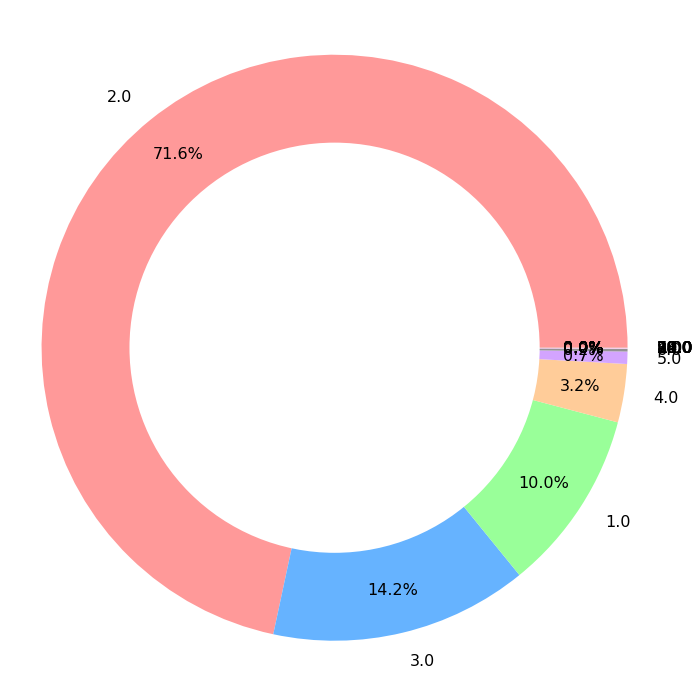

Most common 'party_count' for severity level of 'property damage only' is '2.0'


2.0

In [255]:
pie_chart(df, cs_labels[0], 'party_count', colors)

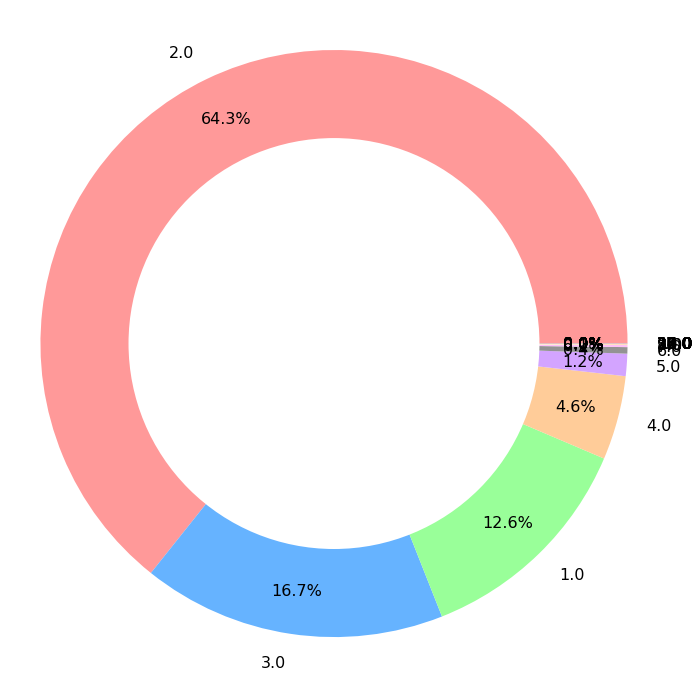

Most common 'party_count' for severity level of 'injury' is '2.0'


2.0

In [256]:
pie_chart(df, cs_labels[1], 'party_count', colors)

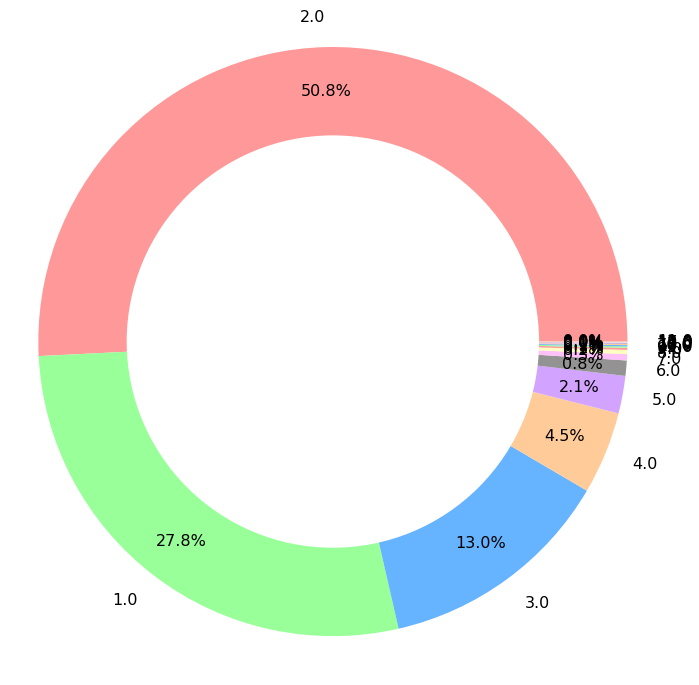

Most common 'party_count' for severity level of 'fatal' is '2.0'


2.0

In [257]:
colors = ['#ff9999','#99ff99','#66b3ff', '#ffcc99', '#D3A4FF', '#939393', '#FEC0F8', '#FEFEC0']
pie_chart(df, cs_labels[2], 'party_count', colors)

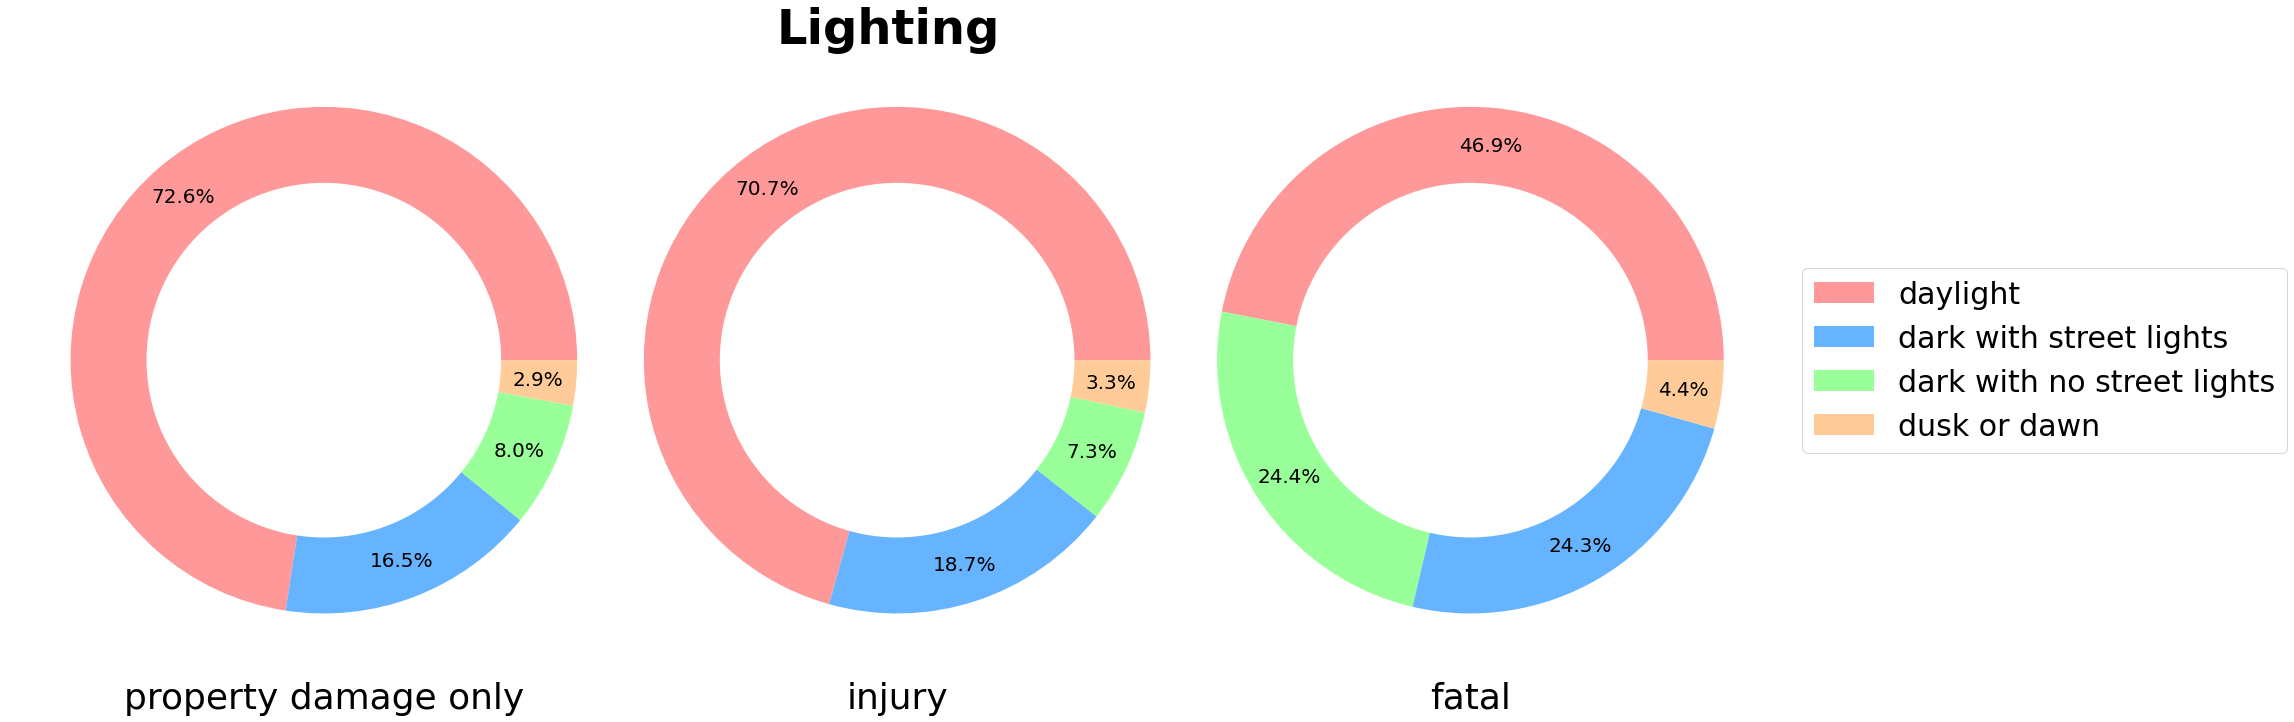

In [220]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))

feat = 'lighting'

colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#D3A4FF', '#939393', '#FEC0F8', '#FEFEC0']
spec_df = df.loc[df['collision_severity'] == cs_labels[0]][feat]
labs1 = list(spec_df.value_counts().index.tolist())
freqs = list(spec_df.value_counts())
wedges, texts, autotexts = ax[0].pie(freqs, autopct='%1.1f%%', colors=colors, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
ax[0].add_artist(centre_circle)
ax[0].set_xlabel(cs_labels[0], fontsize=36)


spec_df = df.loc[df['collision_severity'] == cs_labels[1]][feat]
labs = list(spec_df.value_counts().index.tolist())
freqs = list(spec_df.value_counts())
ax[1].pie(freqs, autopct='%1.1f%%', colors=colors, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
ax[1].add_artist(centre_circle)
ax[1].set_xlabel(cs_labels[1], fontsize=36)

colors = ['#ff9999','#99ff99', '#66b3ff', '#ffcc99', '#D3A4FF', '#939393', '#FEC0F8', '#FEFEC0']
spec_df = df.loc[df['collision_severity'] == cs_labels[2]][feat]
labs = list(spec_df.value_counts().index.tolist())
freqs = list(spec_df.value_counts())
ax[2].pie(freqs, autopct='%1.1f%%', colors=colors, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
ax[2].add_artist(centre_circle)
ax[2].set_xlabel(cs_labels[2], fontsize=36)

lgd = ax[2].legend(wedges, labs1,
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1),
          prop={'size': 30})


fig.suptitle('Lighting', fontsize=48, fontweight="bold", x = 0.38, y=1)
plt.tight_layout(pad=-3.0)

plt.savefig('{0}.png'.format(feat), bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [222]:
plt.figure(figsize=(30,10))

feat = 'lighting'

feat_change_sev = np.zeros((3, 4))

for j in range(len(cs_labels)):
    spec_df = df.loc[df['collision_severity'] == cs_labels[j]][feat]
    labs = list(spec_df.value_counts().index.tolist())
    freqs = list(spec_df.value_counts())
    print(labs)
    prct = [100*freqs[i]/cs_counts[j] for i in range(len(freqs))]
    feat_change_sev[j,:] = prct

['daylight', 'dark with street lights', 'dark with no street lights', 'dusk or dawn']
['daylight', 'dark with street lights', 'dark with no street lights', 'dusk or dawn']
['daylight', 'dark with no street lights', 'dark with street lights', 'dusk or dawn']


<Figure size 2160x720 with 0 Axes>

In [223]:
day = [feat_change_sev[0,0], feat_change_sev[1,0], feat_change_sev[2,0]]
sl = [feat_change_sev[0,1], feat_change_sev[1,1], feat_change_sev[2,2]]
nosl = [feat_change_sev[0,2], feat_change_sev[1,2], feat_change_sev[2,1]]
dusk = [feat_change_sev[0,3], feat_change_sev[1,3], feat_change_sev[2,3]]

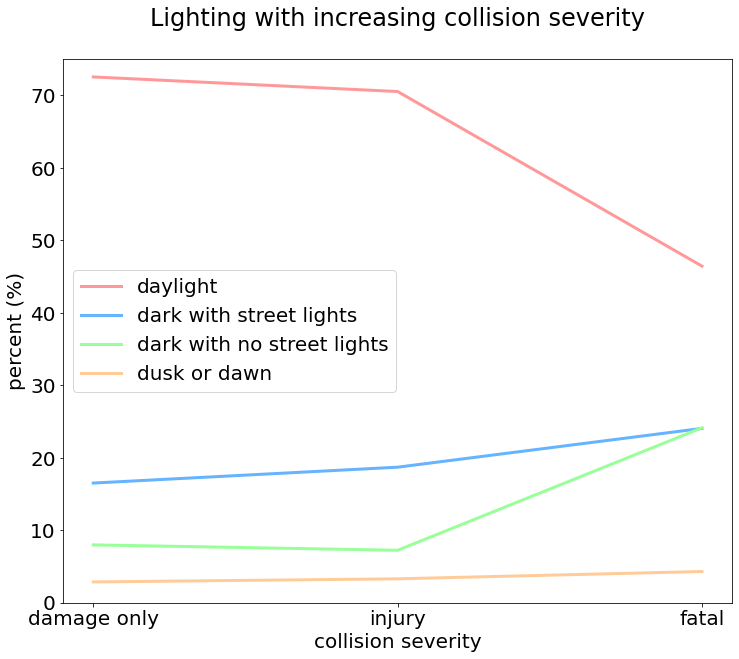

In [224]:
fig = plt.figure(figsize=(12,10))
ax  = fig.add_subplot(111)
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#D3A4FF', '#939393', '#FEC0F8', '#FDFF5C']
lw = 3
ax.plot([0,1,2], day,  color=colors[0], linewidth=lw, label=labs[0])
ax.plot([0,1,2], sl,  color=colors[1], linewidth=lw, label=labs[2])
ax.plot([0,1,2], nosl, color=colors[2], linewidth=lw, label=labs[1])
ax.plot([0,1,2], dusk,   color=colors[3], linewidth=lw, label=labs[3])

ax.set_ylim(0,75)
plt.legend(loc='center left')
ttl = plt.title('Lighting with increasing collision severity')
ttl.set_position([.5, 1.05])
plt.xlabel('collision severity')
plt.xticks(np.arange(3), ['damage only', 'injury', 'fatal'])
plt.ylabel('percent (%)')
plt.savefig('{0}_severity.png'.format(feat), dpi=300)
plt.show()

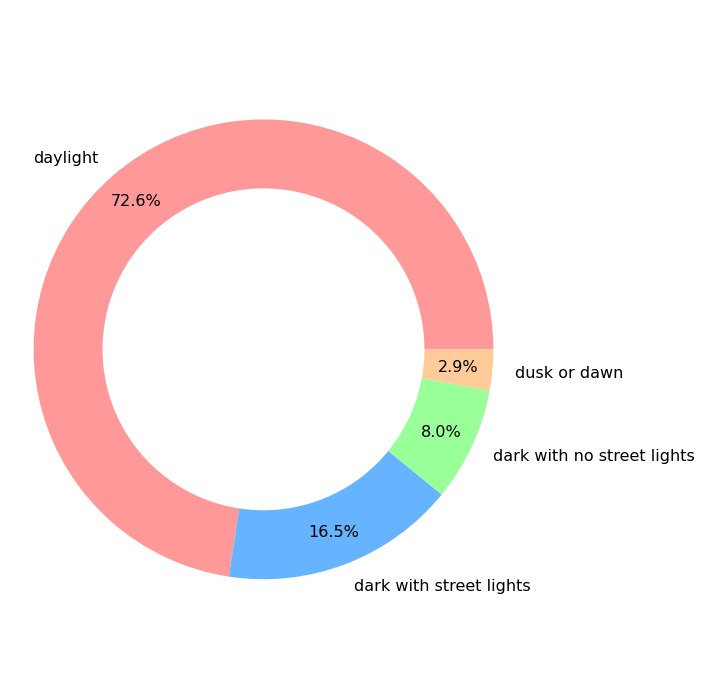

Most common 'lighting' for severity level of 'property damage only' is 'daylight'


'daylight'

In [258]:
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#D3A4FF', '#939393', '#FEC0F8', '#FEFEC0']
pie_chart(df, cs_labels[0], 'lighting', colors)

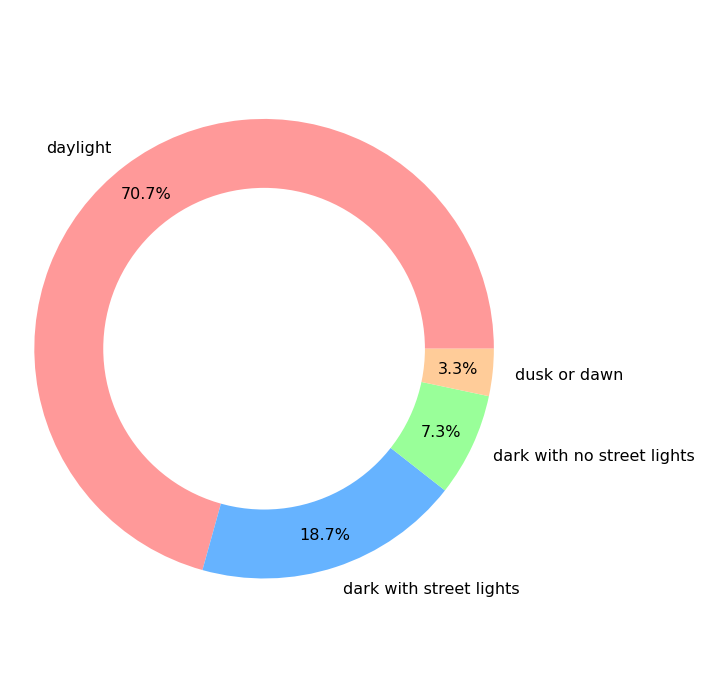

Most common 'lighting' for severity level of 'injury' is 'daylight'


'daylight'

In [259]:
pie_chart(df, cs_labels[1], 'lighting', colors)

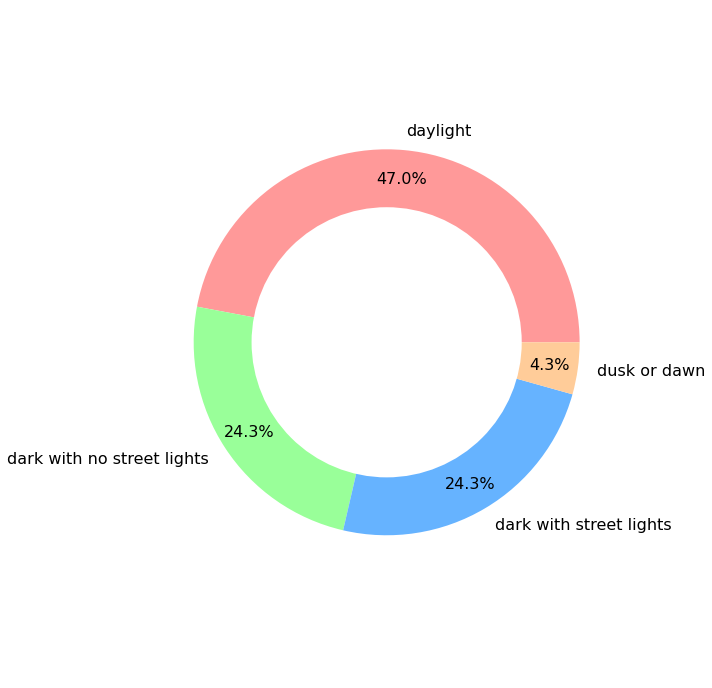

Most common 'lighting' for severity level of 'fatal' is 'daylight'


'daylight'

In [261]:
colors = ['#ff9999','#99ff99', '#66b3ff', '#ffcc99', '#D3A4FF', '#939393', '#FEC0F8', '#FEFEC0']
pie_chart(df, cs_labels[2], 'lighting', colors)

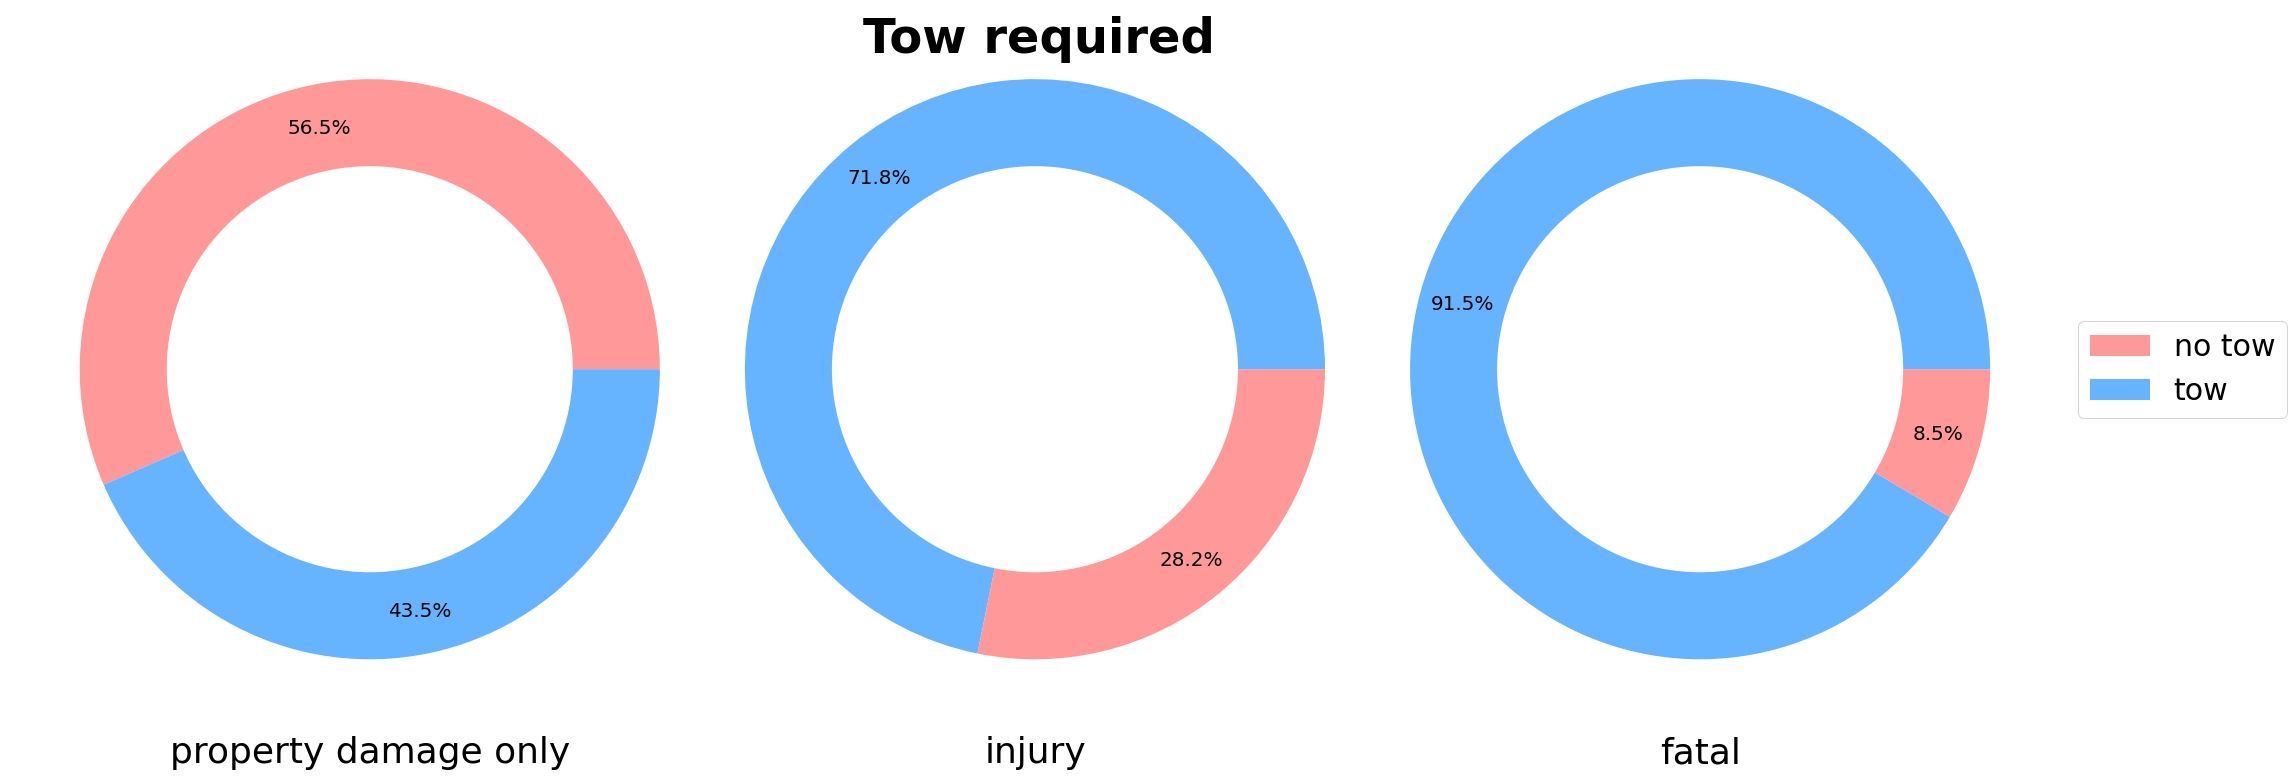

In [227]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))

feat = 'tow_away'

colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#D3A4FF', '#939393', '#FEC0F8', '#FEFEC0']
spec_df = df.loc[df['collision_severity'] == cs_labels[0]][feat]
labs1 = list(spec_df.value_counts().index.tolist())
freqs = list(spec_df.value_counts())
wedges, texts, autotexts = ax[0].pie(freqs, autopct='%1.1f%%', colors=colors, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
ax[0].add_artist(centre_circle)
ax[0].set_xlabel(cs_labels[0], fontsize=36)

colors = ['#66b3ff', '#ff9999']
spec_df = df.loc[df['collision_severity'] == cs_labels[1]][feat]
labs = list(spec_df.value_counts().index.tolist())
freqs = list(spec_df.value_counts())
ax[1].pie(freqs, autopct='%1.1f%%', colors=colors, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
ax[1].add_artist(centre_circle)
ax[1].set_xlabel(cs_labels[1], fontsize=36)

spec_df = df.loc[df['collision_severity'] == cs_labels[2]][feat]
labs = list(spec_df.value_counts().index.tolist())
freqs = list(spec_df.value_counts())
ax[2].pie(freqs, autopct='%1.1f%%', colors=colors, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
ax[2].add_artist(centre_circle)
ax[2].set_xlabel(cs_labels[2], fontsize=36)

lgd = ax[2].legend(wedges, ['no tow', 'tow'],
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1),
          prop={'size': 30})


fig.suptitle('Tow required', fontsize=48, fontweight="bold", x = 0.45, y=1)
plt.tight_layout(pad=-3.0)

plt.savefig('{0}.png'.format(feat), bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [229]:
plt.figure(figsize=(30,10))

feat = 'tow_away'

feat_change_sev = np.zeros((3, 2))

for j in range(len(cs_labels)):
    spec_df = df.loc[df['collision_severity'] == cs_labels[j]][feat]
    labs = list(spec_df.value_counts().index.tolist())
    freqs = list(spec_df.value_counts())
    print(labs)
    prct = [100*freqs[i]/cs_counts[j] for i in range(len(freqs))]
    feat_change_sev[j,:] = prct

[0.0, 1.0]
[1.0, 0.0]
[1.0, 0.0]


<Figure size 2160x720 with 0 Axes>

In [230]:
no_tow = [feat_change_sev[0,0], feat_change_sev[1,1], feat_change_sev[2,1]]
tow = [feat_change_sev[0,1], feat_change_sev[1,0], feat_change_sev[2,0]]

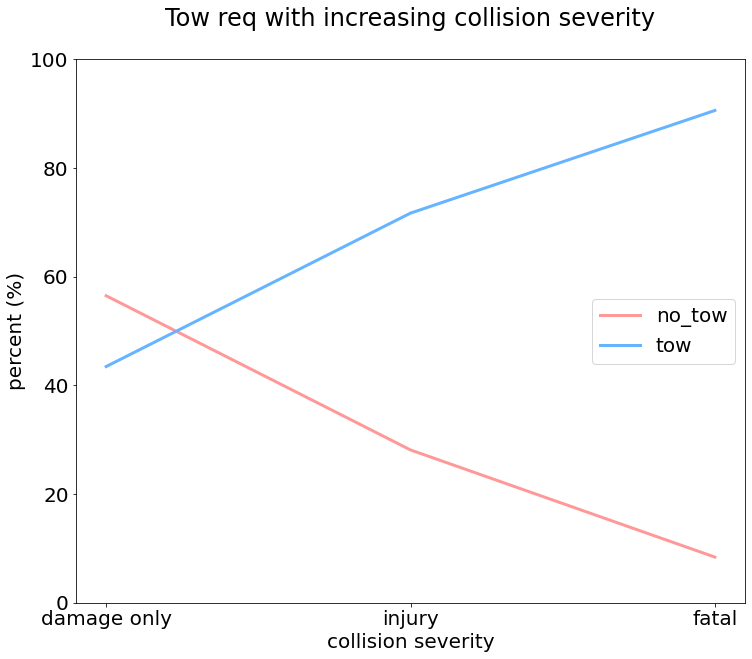

In [233]:
fig = plt.figure(figsize=(12,10))
ax  = fig.add_subplot(111)
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#D3A4FF', '#939393', '#FEC0F8', '#FDFF5C']
lw = 3
ax.plot([0,1,2], no_tow,  color=colors[0], linewidth=lw, label='no_tow')
ax.plot([0,1,2], tow,  color=colors[1], linewidth=lw, label='tow')

ax.set_ylim(0,100)
plt.legend(loc='center right')
ttl = plt.title('Tow req with increasing collision severity')
ttl.set_position([.5, 1.05])
plt.xlabel('collision severity')
plt.xticks(np.arange(3), ['damage only', 'injury', 'fatal'])
plt.ylabel('percent (%)')
plt.savefig('{0}_severity.png'.format(feat), dpi=300)
plt.show()

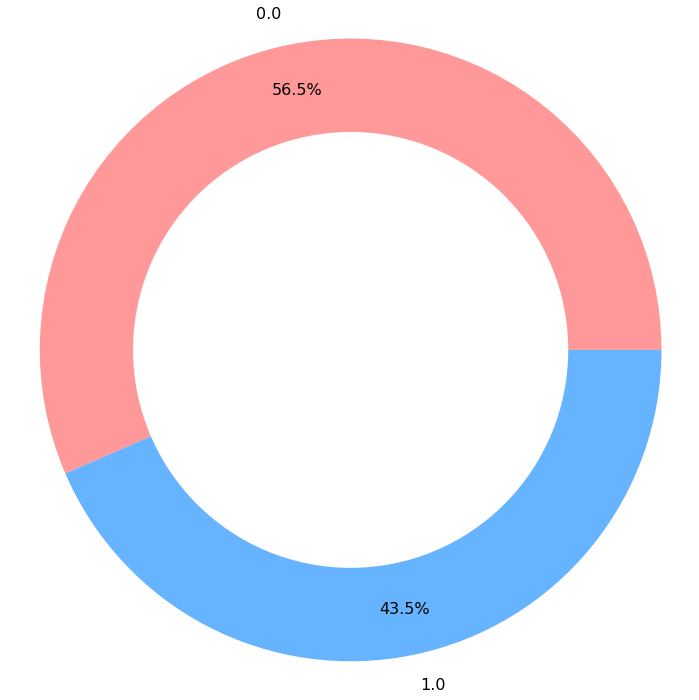

Most common 'tow_away' for severity level of 'property damage only' is '0.0'


0.0

In [262]:
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#D3A4FF', '#939393', '#FEC0F8', '#FEFEC0']
pie_chart(df, cs_labels[0], 'tow_away', colors)

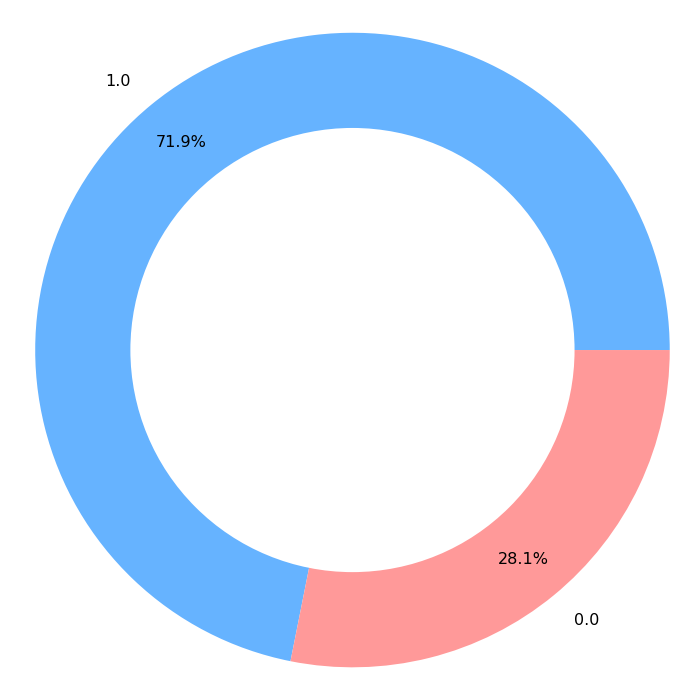

Most common 'tow_away' for severity level of 'injury' is '1.0'


1.0

In [263]:
colors = ['#66b3ff', '#ff9999']
pie_chart(df, cs_labels[1], 'tow_away', colors)

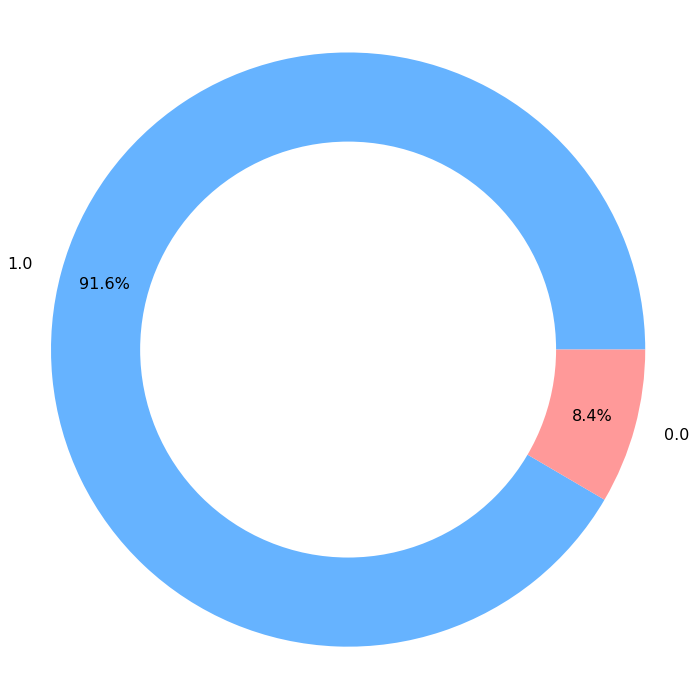

Most common 'tow_away' for severity level of 'fatal' is '1.0'


1.0

In [264]:
pie_chart(df, cs_labels[2], 'tow_away', colors)

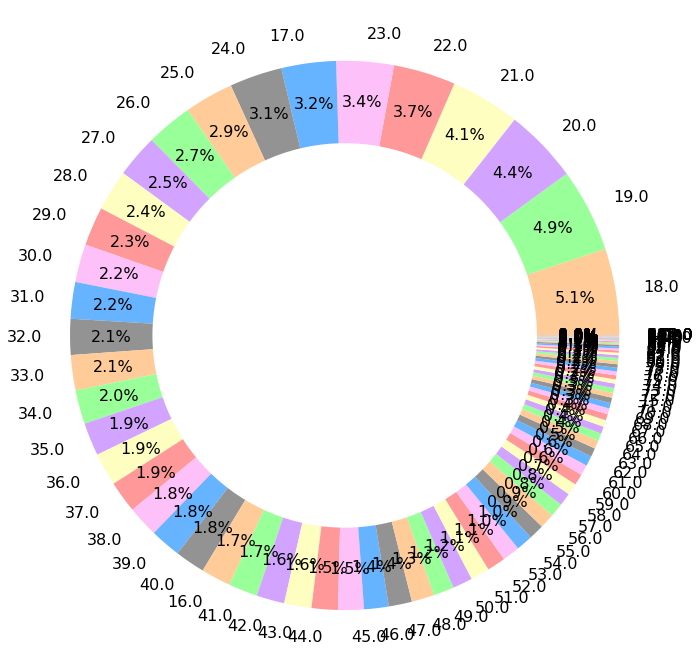

Most common 'party_age' for severity level of 'property damage only' is '18.0'


18.0

In [221]:
pie_chart(df, cs_labels[0], 'party_age', colors)

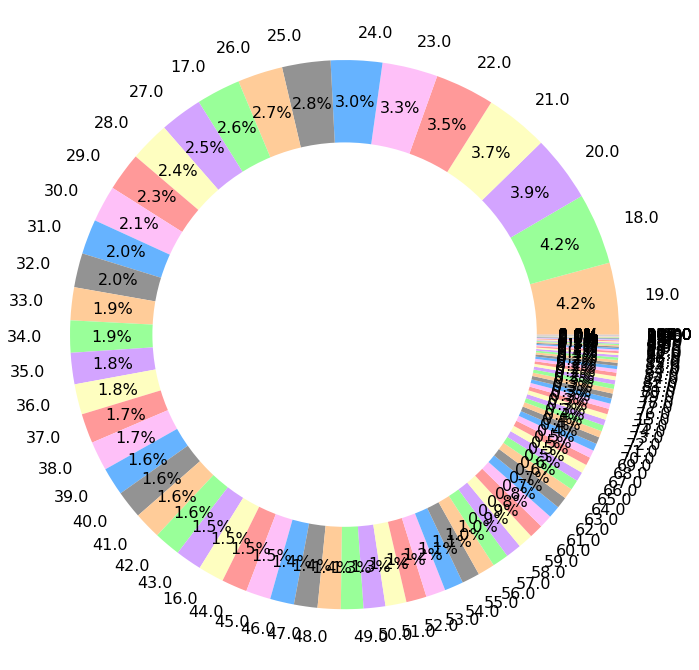

Most common 'party_age' for severity level of 'injury' is '19.0'


19.0

In [222]:
pie_chart(df, cs_labels[1], 'party_age', colors)

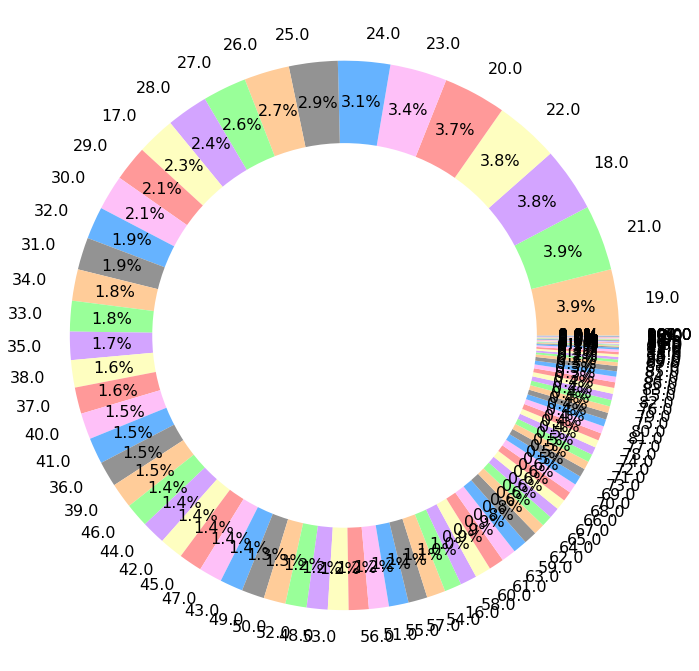

Most common 'party_age' for severity level of 'fatal' is '19.0'


19.0

In [223]:
pie_chart(df, cs_labels[2], 'party_age', colors)

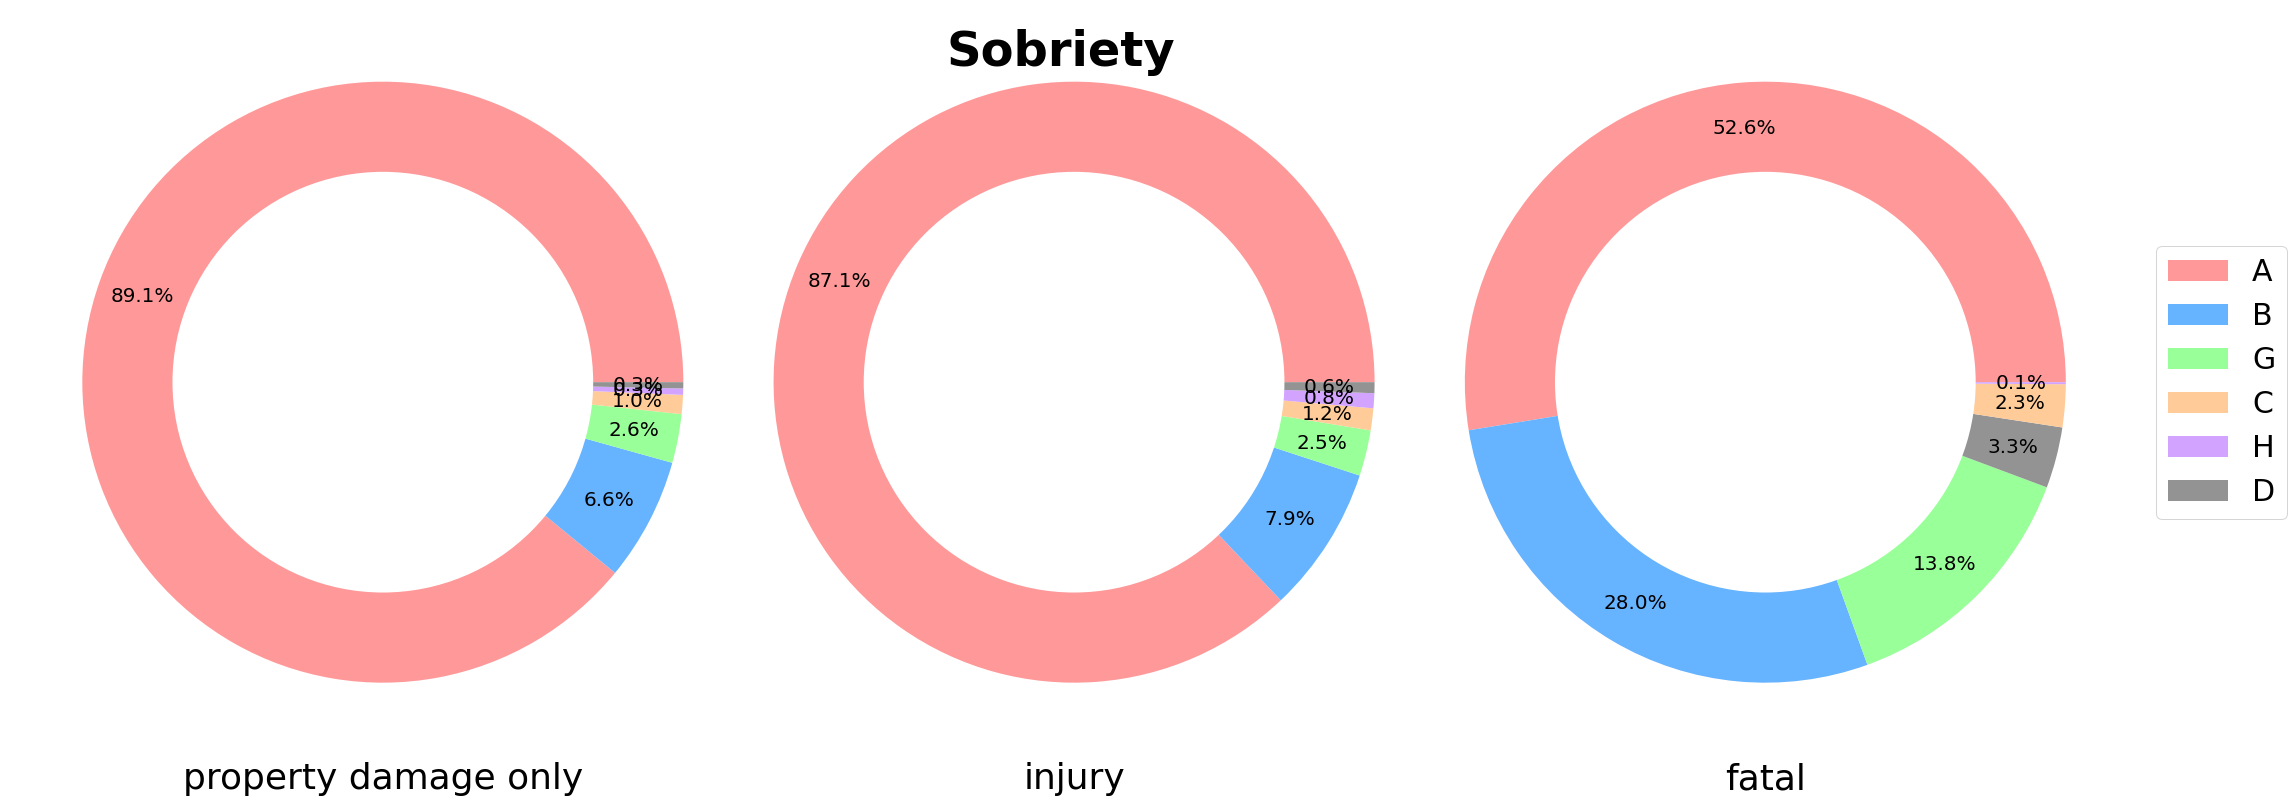

In [237]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))

feat = 'party_sobriety'

colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#D3A4FF', '#939393', '#FEC0F8', '#FEFEC0']
spec_df = df.loc[df['collision_severity'] == cs_labels[0]][feat]
labs1 = list(spec_df.value_counts().index.tolist())
freqs = list(spec_df.value_counts())
wedges, texts, autotexts = ax[0].pie(freqs, autopct='%1.1f%%', colors=colors, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
ax[0].add_artist(centre_circle)
ax[0].set_xlabel(cs_labels[0], fontsize=36)

spec_df = df.loc[df['collision_severity'] == cs_labels[1]][feat]
labs = list(spec_df.value_counts().index.tolist())
freqs = list(spec_df.value_counts())
ax[1].pie(freqs, autopct='%1.1f%%', colors=colors, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
ax[1].add_artist(centre_circle)
ax[1].set_xlabel(cs_labels[1], fontsize=36)

colors = ['#ff9999','#66b3ff','#99ff99','#939393', '#ffcc99', '#D3A4FF', '#939393', '#FEFEC0', '#FEC0F8']
spec_df = df.loc[df['collision_severity'] == cs_labels[2]][feat]
labs = list(spec_df.value_counts().index.tolist())
freqs = list(spec_df.value_counts())
ax[2].pie(freqs, autopct='%1.1f%%', colors=colors, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
ax[2].add_artist(centre_circle)
ax[2].set_xlabel(cs_labels[2], fontsize=36)

lgd = ax[2].legend(wedges, labs1,
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1),
          prop={'size': 30})


fig.suptitle('Sobriety', fontsize=48, fontweight="bold", x = 0.46, y=1)
plt.tight_layout(pad=-3.0)

plt.savefig('{0}.png'.format(feat), bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

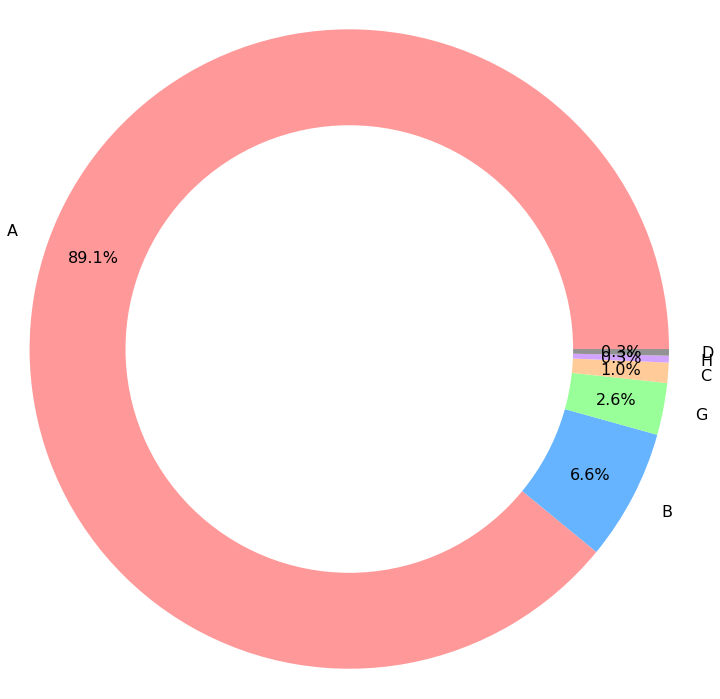

Most common 'party_sobriety' for severity level of 'property damage only' is 'A'


'A'

In [265]:
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#D3A4FF', '#939393', '#FEC0F8', '#FEFEC0']
pie_chart(df, cs_labels[0], 'party_sobriety', colors)

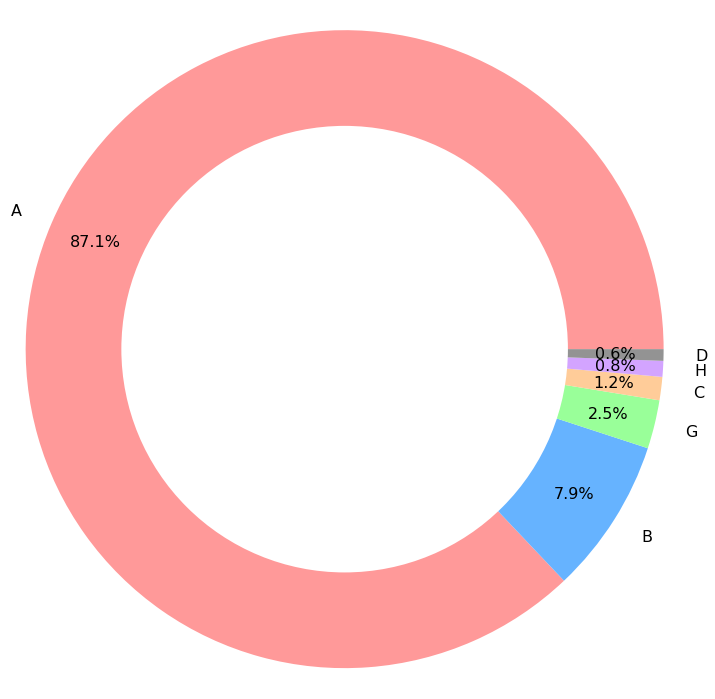

Most common 'party_sobriety' for severity level of 'injury' is 'A'


'A'

In [266]:
pie_chart(df, cs_labels[1], 'party_sobriety', colors)

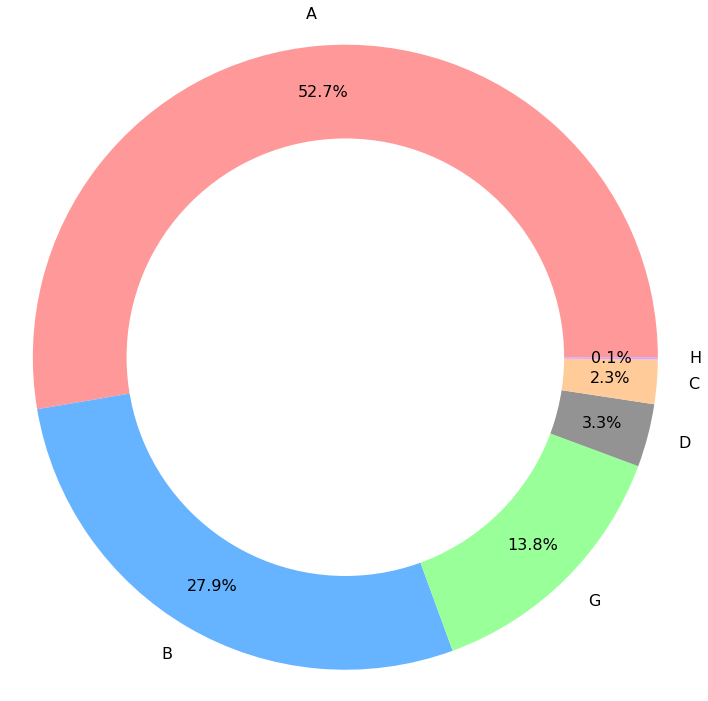

Most common 'party_sobriety' for severity level of 'fatal' is 'A'


'A'

In [270]:
colors = ['#ff9999','#66b3ff','#99ff99','#939393', '#ffcc99', '#D3A4FF', '#939393', '#FEFEC0', '#FEC0F8']
pie_chart(df, cs_labels[2], 'party_sobriety', colors)

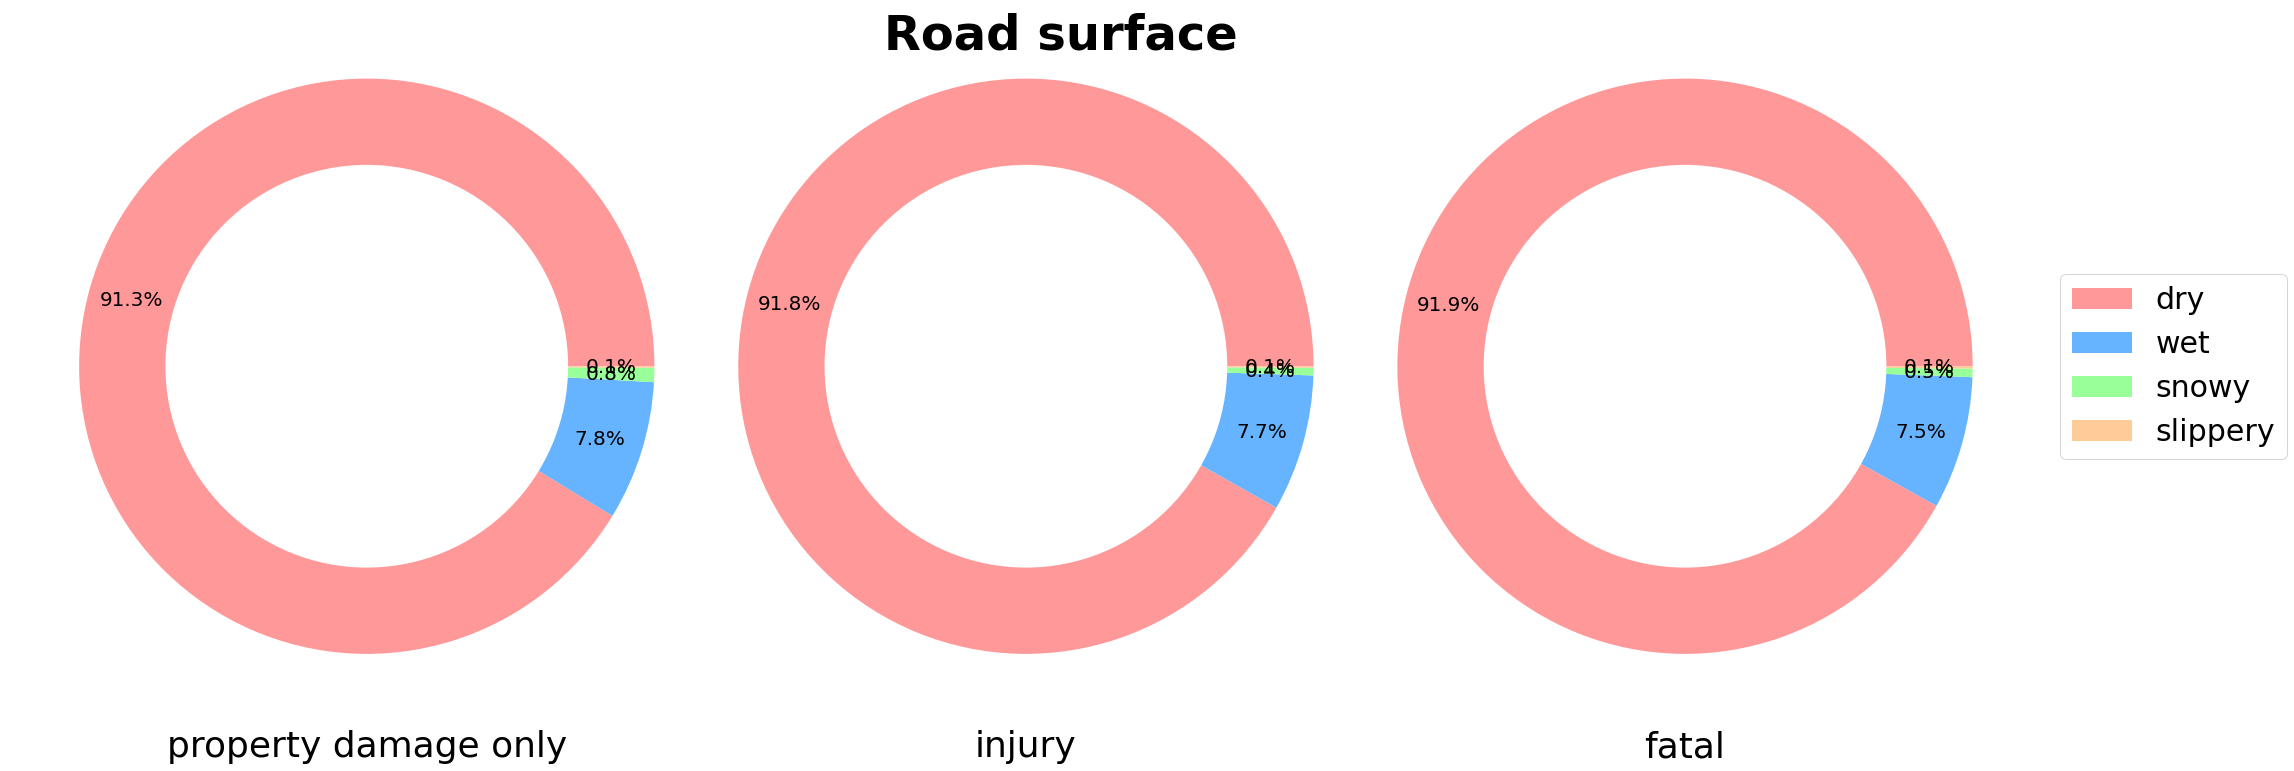

In [238]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))

feat = 'road_surface'

colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#D3A4FF', '#939393', '#FEC0F8', '#FEFEC0']
spec_df = df.loc[df['collision_severity'] == cs_labels[0]][feat]
labs1 = list(spec_df.value_counts().index.tolist())
freqs = list(spec_df.value_counts())
wedges, texts, autotexts = ax[0].pie(freqs, autopct='%1.1f%%', colors=colors, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
ax[0].add_artist(centre_circle)
ax[0].set_xlabel(cs_labels[0], fontsize=36)

spec_df = df.loc[df['collision_severity'] == cs_labels[1]][feat]
labs = list(spec_df.value_counts().index.tolist())
freqs = list(spec_df.value_counts())
ax[1].pie(freqs, autopct='%1.1f%%', colors=colors, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
ax[1].add_artist(centre_circle)
ax[1].set_xlabel(cs_labels[1], fontsize=36)

spec_df = df.loc[df['collision_severity'] == cs_labels[2]][feat]
labs = list(spec_df.value_counts().index.tolist())
freqs = list(spec_df.value_counts())
ax[2].pie(freqs, autopct='%1.1f%%', colors=colors, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
ax[2].add_artist(centre_circle)
ax[2].set_xlabel(cs_labels[2], fontsize=36)

lgd = ax[2].legend(wedges, labs1,
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1),
          prop={'size': 30})


fig.suptitle('Road surface', fontsize=48, fontweight="bold", x = 0.46, y=1)
plt.tight_layout(pad=-3.0)

plt.savefig('{0}.png'.format(feat), bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

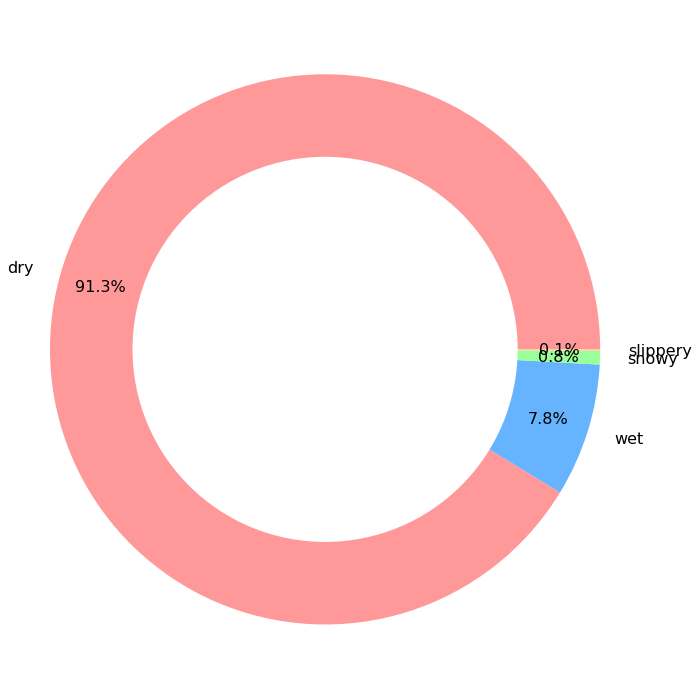

Most common 'road_surface' for severity level of 'property damage only' is 'dry'


'dry'

In [274]:
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#D3A4FF', '#939393', '#FEC0F8', '#FEFEC0']
pie_chart(df, cs_labels[0], 'road_surface', colors)

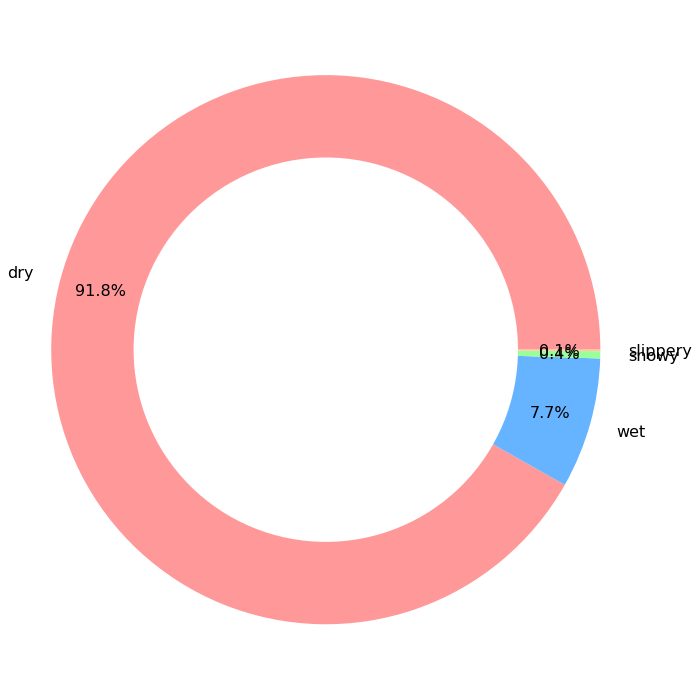

Most common 'road_surface' for severity level of 'injury' is 'dry'


'dry'

In [275]:
pie_chart(df, cs_labels[1], 'road_surface', colors)

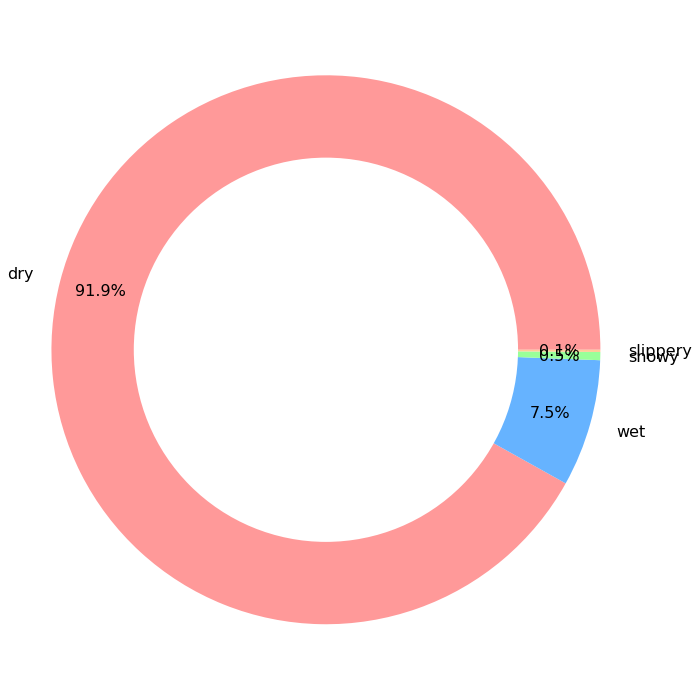

Most common 'road_surface' for severity level of 'fatal' is 'dry'


'dry'

In [276]:
pie_chart(df, cs_labels[2], 'road_surface', colors)

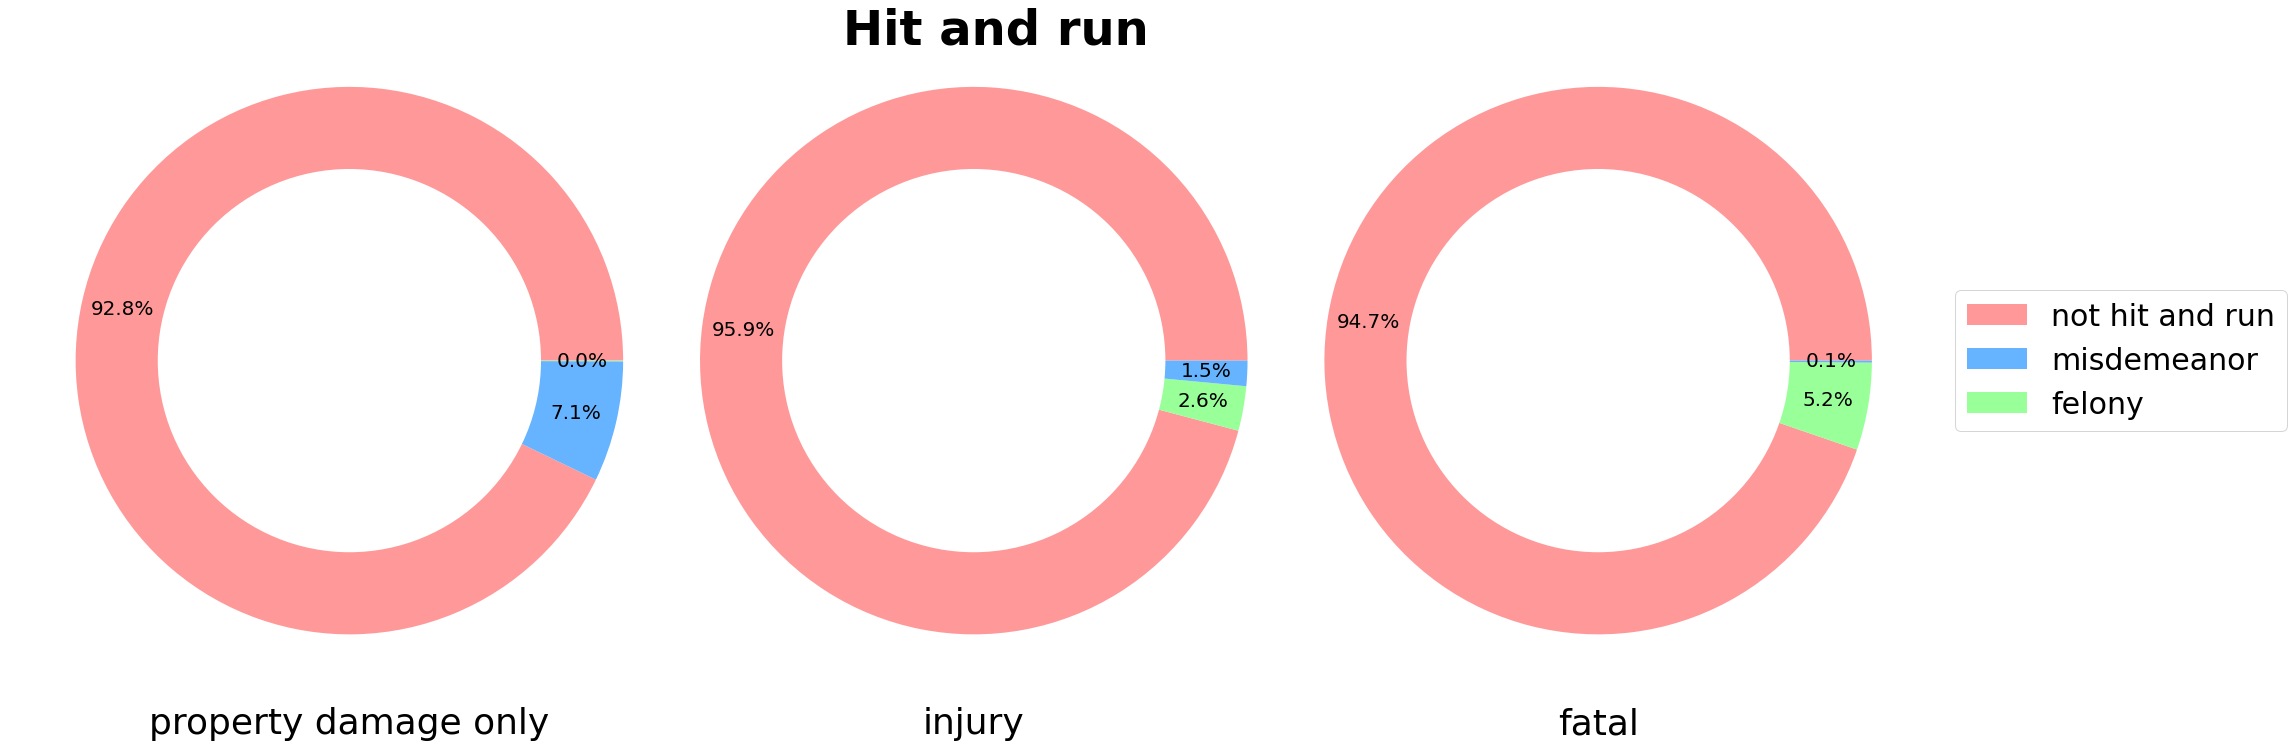

In [240]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))

feat = 'hit_and_run'

colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#D3A4FF', '#939393', '#FEC0F8', '#FEFEC0']
spec_df = df.loc[df['collision_severity'] == cs_labels[0]][feat]
labs1 = list(spec_df.value_counts().index.tolist())
freqs = list(spec_df.value_counts())
wedges, texts, autotexts = ax[0].pie(freqs, autopct='%1.1f%%', colors=colors, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
ax[0].add_artist(centre_circle)
ax[0].set_xlabel(cs_labels[0], fontsize=36)

colors = ['#ff9999','#99ff99', '#66b3ff']
spec_df = df.loc[df['collision_severity'] == cs_labels[1]][feat]
labs = list(spec_df.value_counts().index.tolist())
freqs = list(spec_df.value_counts())
ax[1].pie(freqs, autopct='%1.1f%%', colors=colors, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
ax[1].add_artist(centre_circle)
ax[1].set_xlabel(cs_labels[1], fontsize=36)

spec_df = df.loc[df['collision_severity'] == cs_labels[2]][feat]
labs = list(spec_df.value_counts().index.tolist())
freqs = list(spec_df.value_counts())
ax[2].pie(freqs, autopct='%1.1f%%', colors=colors, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
ax[2].add_artist(centre_circle)
ax[2].set_xlabel(cs_labels[2], fontsize=36)

lgd = ax[2].legend(wedges, labs1,
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1),
          prop={'size': 30})


fig.suptitle('Hit and run', fontsize=48, fontweight="bold", x = 0.43, y=1)
plt.tight_layout(pad=-3.0)

plt.savefig('{0}.png'.format(feat), bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

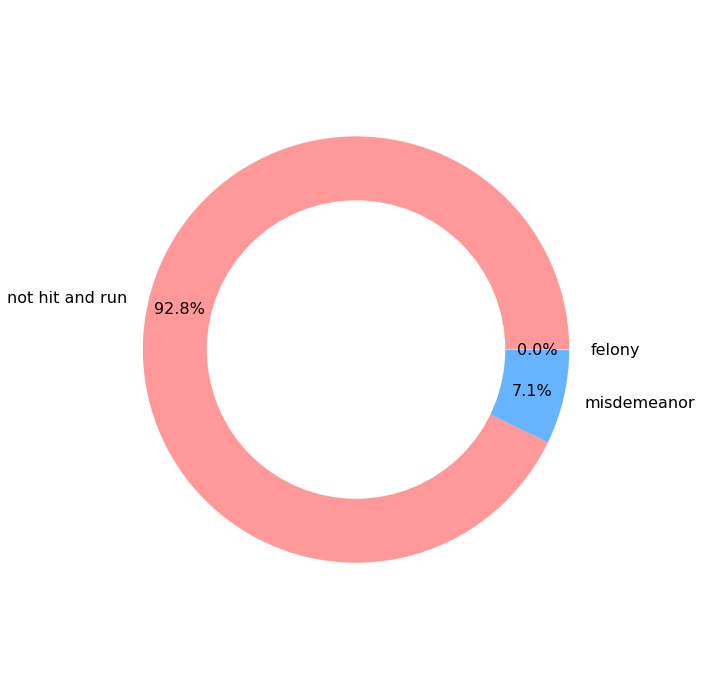

Most common 'hit_and_run' for severity level of 'property damage only' is 'not hit and run'


'not hit and run'

In [277]:
pie_chart(df, cs_labels[0], 'hit_and_run', colors)

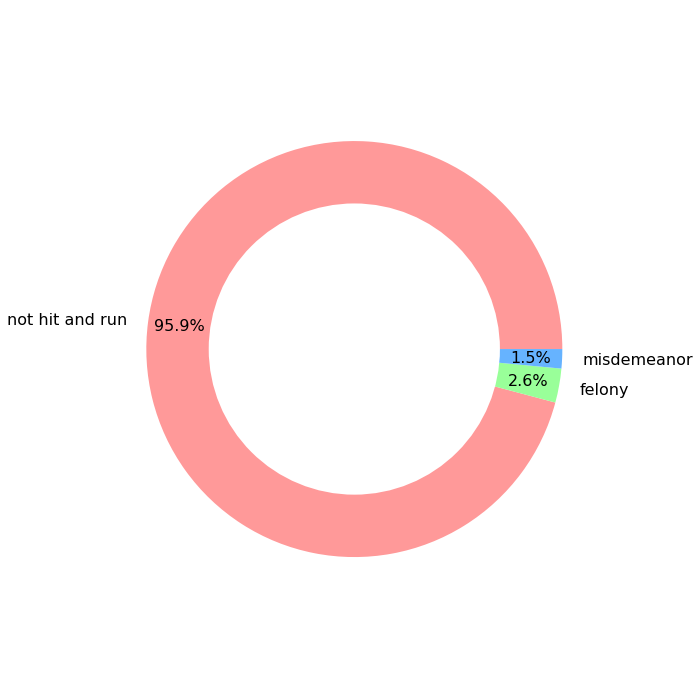

Most common 'hit_and_run' for severity level of 'injury' is 'not hit and run'


'not hit and run'

In [280]:
colors = ['#ff9999','#99ff99', '#66b3ff']
pie_chart(df, cs_labels[1], 'hit_and_run', colors)

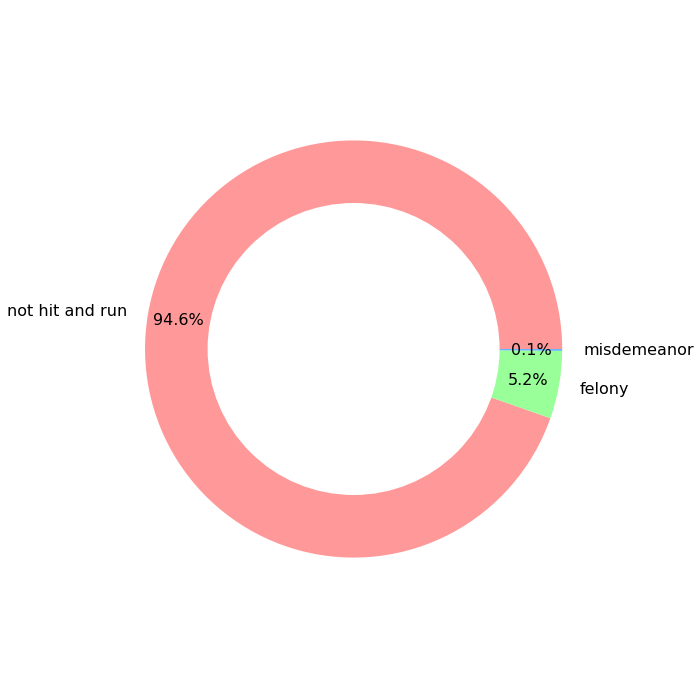

Most common 'hit_and_run' for severity level of 'fatal' is 'not hit and run'


'not hit and run'

In [281]:
pie_chart(df, cs_labels[2], 'hit_and_run', colors)

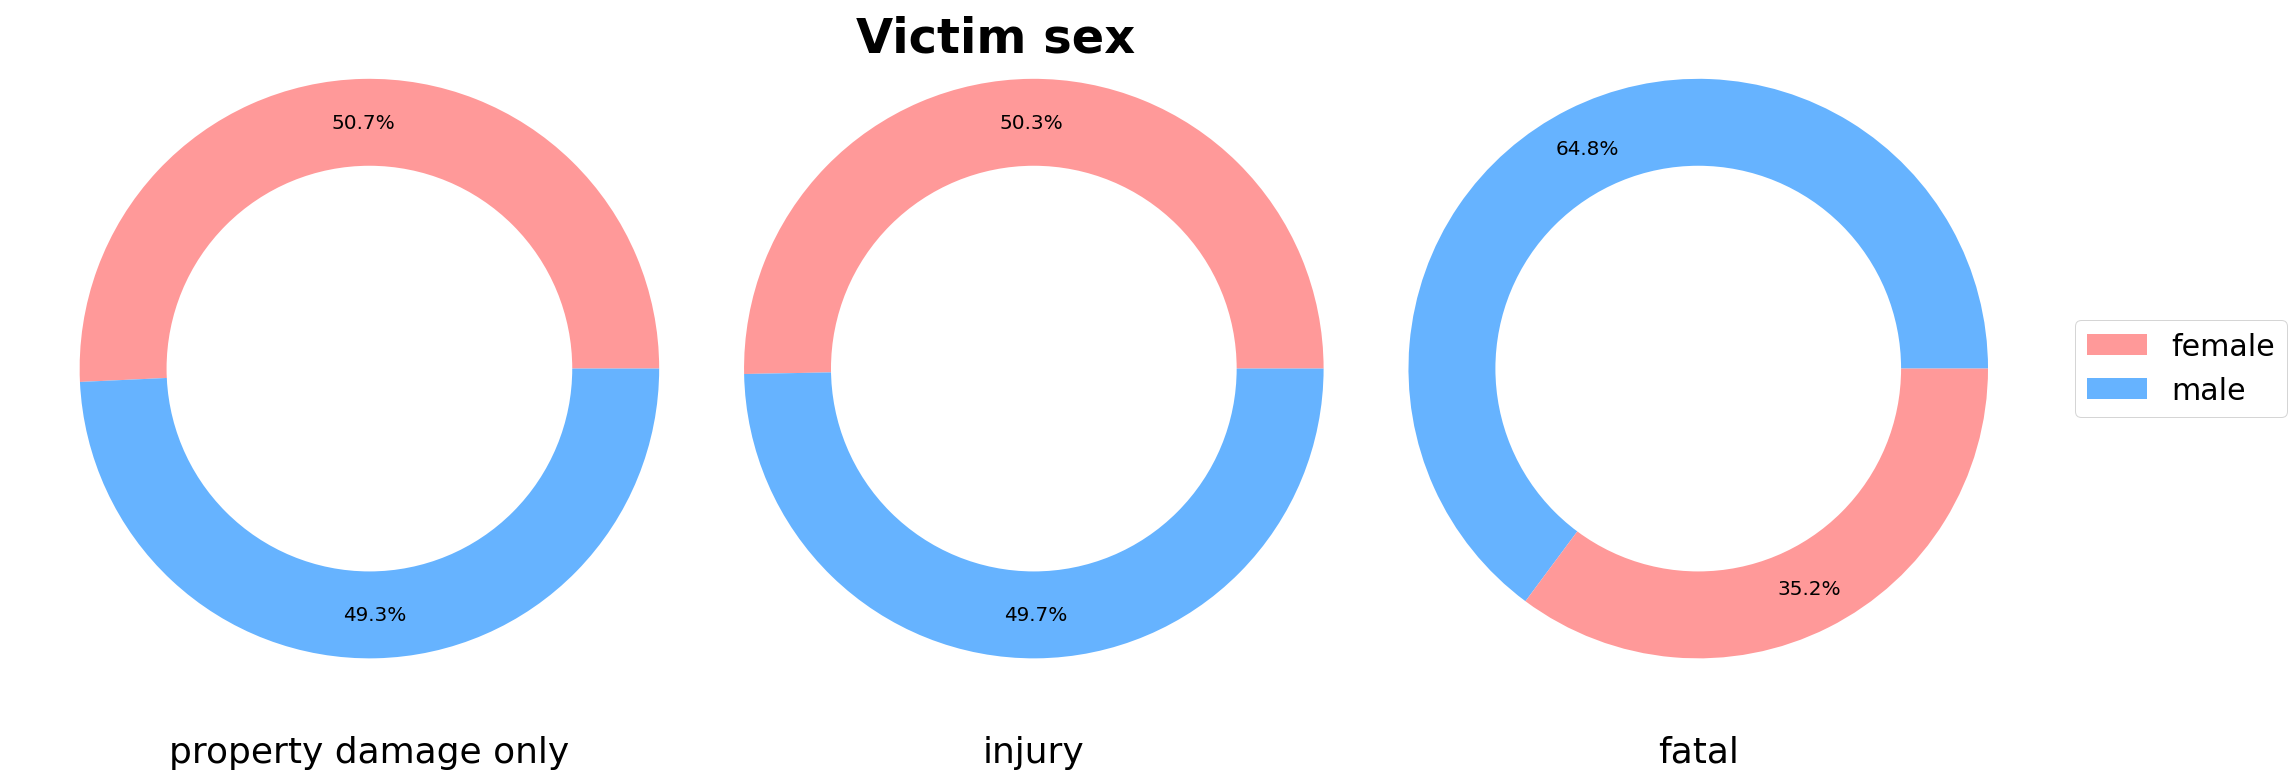

In [241]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))

feat = 'victim_sex'

colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#D3A4FF', '#939393', '#FEC0F8', '#FEFEC0']
spec_df = df.loc[df['collision_severity'] == cs_labels[0]][feat]
labs1 = list(spec_df.value_counts().index.tolist())
freqs = list(spec_df.value_counts())
wedges, texts, autotexts = ax[0].pie(freqs, autopct='%1.1f%%', colors=colors, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
ax[0].add_artist(centre_circle)
ax[0].set_xlabel(cs_labels[0], fontsize=36)

spec_df = df.loc[df['collision_severity'] == cs_labels[1]][feat]
labs = list(spec_df.value_counts().index.tolist())
freqs = list(spec_df.value_counts())
ax[1].pie(freqs, autopct='%1.1f%%', colors=colors, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
ax[1].add_artist(centre_circle)
ax[1].set_xlabel(cs_labels[1], fontsize=36)

colors = ['#66b3ff','#ff9999']
spec_df = df.loc[df['collision_severity'] == cs_labels[2]][feat]
labs = list(spec_df.value_counts().index.tolist())
freqs = list(spec_df.value_counts())
ax[2].pie(freqs, autopct='%1.1f%%', colors=colors, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
ax[2].add_artist(centre_circle)
ax[2].set_xlabel(cs_labels[2], fontsize=36)

lgd = ax[2].legend(wedges, labs1,
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1),
          prop={'size': 30})


fig.suptitle('Victim sex', fontsize=48, fontweight="bold", x = 0.43, y=1)
plt.tight_layout(pad=-3.0)

plt.savefig('{0}.png'.format(feat), bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

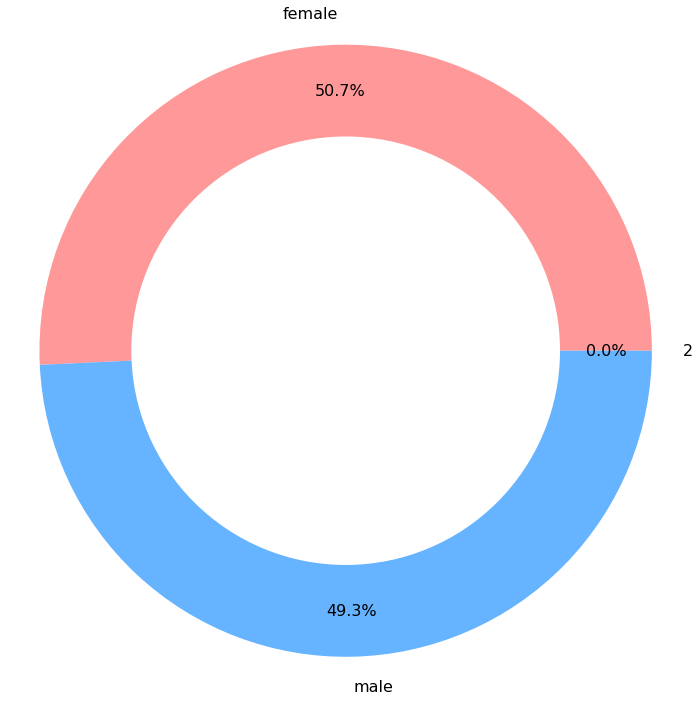

['female', 'male', '2']
Most common 'victim_sex' for severity level of 'property damage only' is 'female'


'female'

In [286]:
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#D3A4FF', '#939393', '#FEC0F8', '#FEFEC0']
pie_chart(df, cs_labels[0], 'victim_sex', colors)

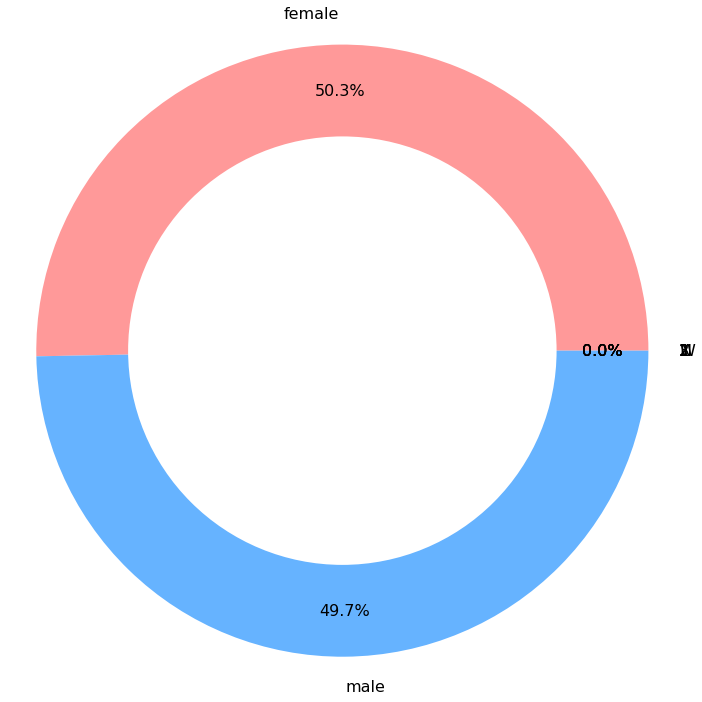

['female', 'male', '3', '2', '1', 'W', 'N']
Most common 'victim_sex' for severity level of 'injury' is 'female'


'female'

In [285]:
pie_chart(df, cs_labels[1], 'victim_sex', colors)

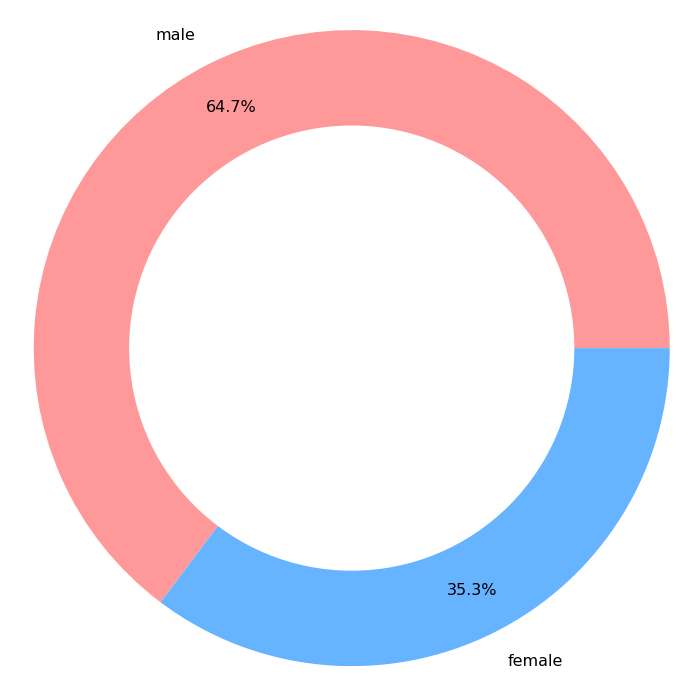

['male', 'female']
Most common 'victim_sex' for severity level of 'fatal' is 'male'


'male'

In [287]:
colors = ['#66b3ff','#ff9999']
pie_chart(df, cs_labels[2], 'victim_sex', colors)

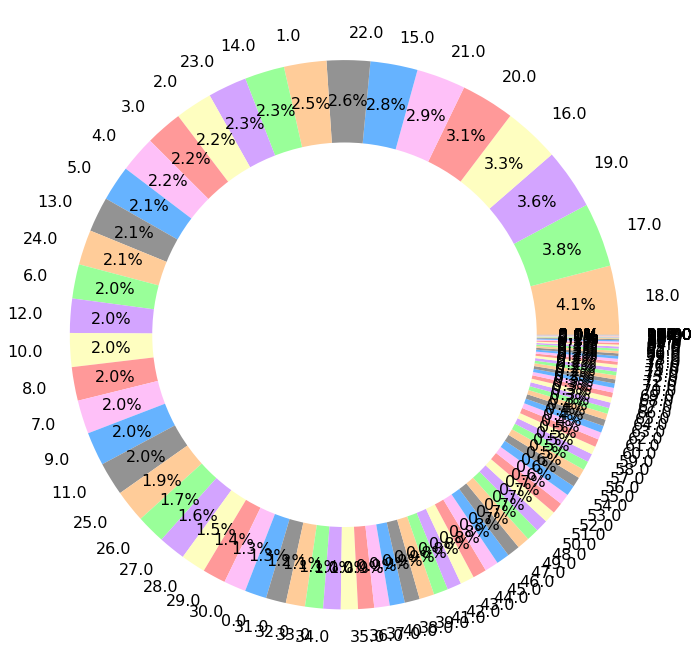

Most common 'victim_age' for severity level of 'property damage only' is '18.0'


18.0

In [236]:
pie_chart(df, cs_labels[0], 'victim_age', colors)

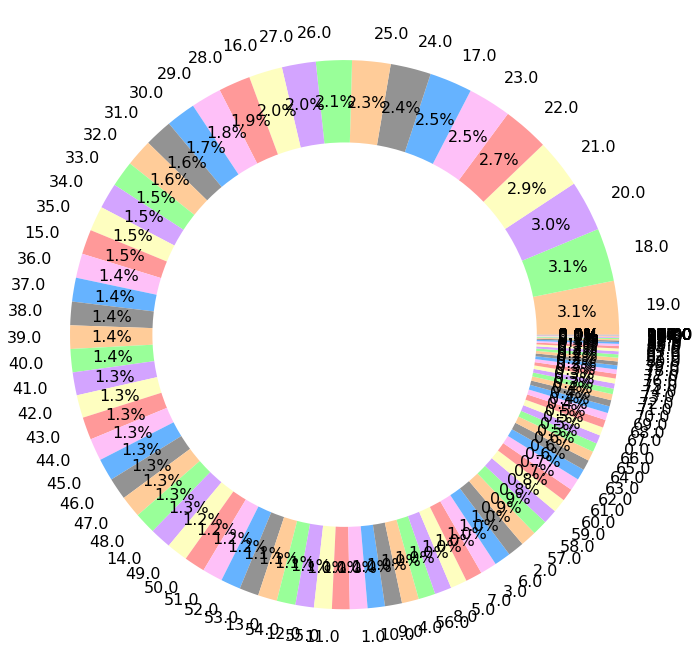

Most common 'victim_age' for severity level of 'injury' is '19.0'


19.0

In [237]:
pie_chart(df, cs_labels[1], 'victim_age', colors)

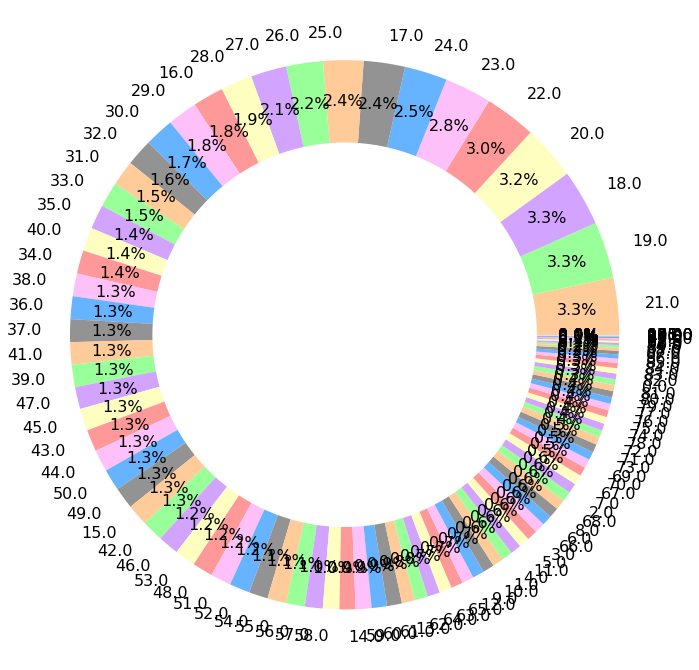

Most common 'victim_age' for severity level of 'fatal' is '21.0'


21.0

In [238]:
pie_chart(df, cs_labels[2], 'victim_age', colors)

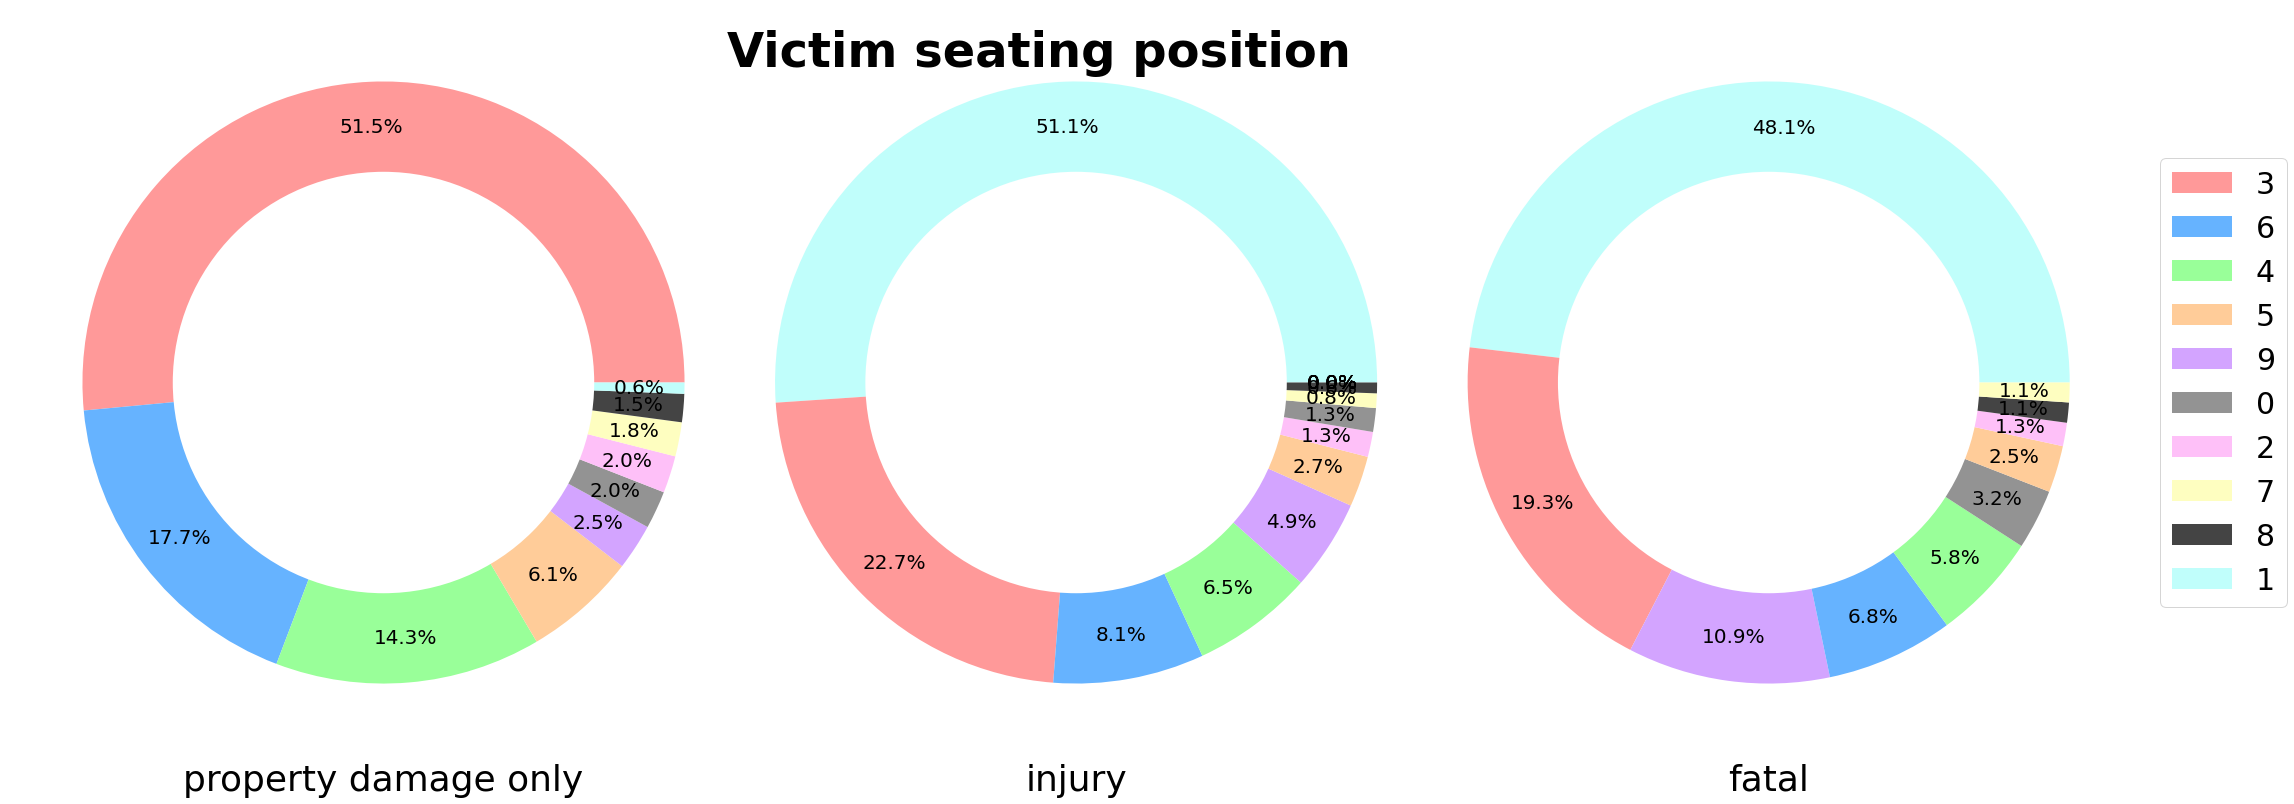

In [243]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))

feat = 'victim_seating_position'

colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#D3A4FF', '#939393', '#FEC0F8', '#FEFEC0', '#444444', '#C0FEFB']
spec_df = df.loc[df['collision_severity'] == cs_labels[0]][feat]
labs1 = list(spec_df.value_counts().index.tolist())
freqs = list(spec_df.value_counts())
wedges, texts, autotexts = ax[0].pie(freqs, autopct='%1.1f%%', colors=colors, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
ax[0].add_artist(centre_circle)
ax[0].set_xlabel(cs_labels[0], fontsize=36)

colors = ['#C0FEFB', '#ff9999', '#66b3ff', '#99ff99', '#D3A4FF','#ffcc99','#FEC0F8', '#939393', '#FEFEC0','#444444']
spec_df = df.loc[df['collision_severity'] == cs_labels[1]][feat]
labs = list(spec_df.value_counts().index.tolist())
freqs = list(spec_df.value_counts())
ax[1].pie(freqs, autopct='%1.1f%%', colors=colors, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
ax[1].add_artist(centre_circle)
ax[1].set_xlabel(cs_labels[1], fontsize=36)

colors = ['#C0FEFB', '#ff9999', '#D3A4FF', '#66b3ff', '#99ff99', '#939393','#ffcc99','#FEC0F8', '#444444', '#FEFEC0']
spec_df = df.loc[df['collision_severity'] == cs_labels[2]][feat]
labs = list(spec_df.value_counts().index.tolist())
freqs = list(spec_df.value_counts())
ax[2].pie(freqs, autopct='%1.1f%%', colors=colors, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
ax[2].add_artist(centre_circle)
ax[2].set_xlabel(cs_labels[2], fontsize=36)

lgd = ax[2].legend(wedges, labs1,
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1),
          prop={'size': 30})


fig.suptitle('Victim seating position', fontsize=48, fontweight="bold", x = 0.45, y=1)
plt.tight_layout(pad=-3.0)

plt.savefig('{0}.png'.format(feat), bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

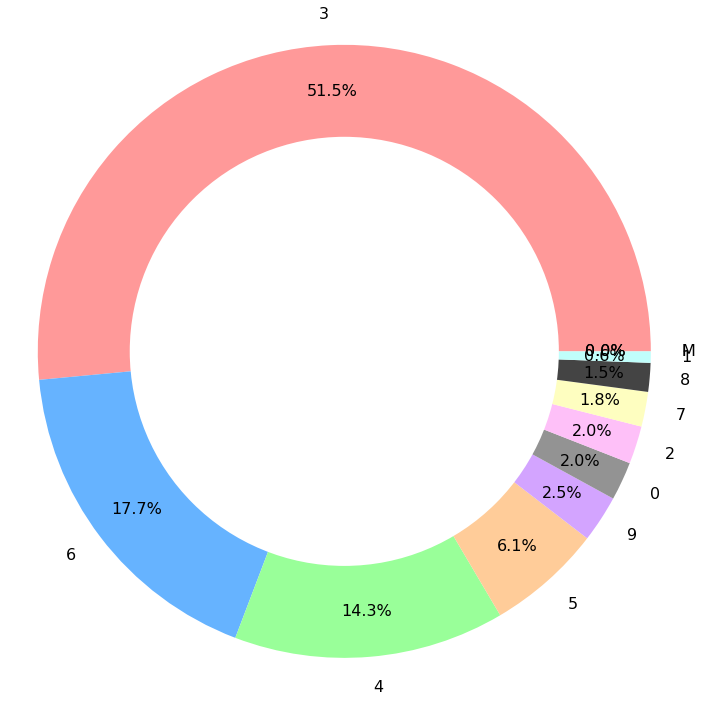

Most common 'victim_seating_position' for severity level of 'property damage only' is '3'


'3'

In [295]:
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#D3A4FF', '#939393', '#FEC0F8', '#FEFEC0', '#444444', '#C0FEFB']
pie_chart(df, cs_labels[0], 'victim_seating_position', colors)

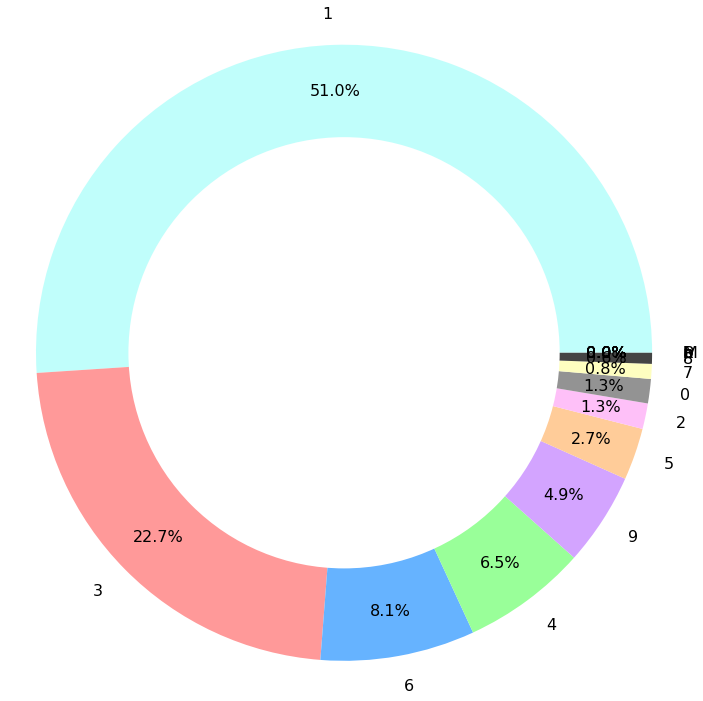

Most common 'victim_seating_position' for severity level of 'injury' is '1'


'1'

In [303]:
colors = ['#C0FEFB', '#ff9999', '#66b3ff', '#99ff99', '#D3A4FF','#ffcc99','#FEC0F8', '#939393', '#FEFEC0','#444444']
#colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#D3A4FF', '#939393', '#FEC0F8', '#FEFEC0', , '#444444']
pie_chart(df, cs_labels[1], 'victim_seating_position', colors)

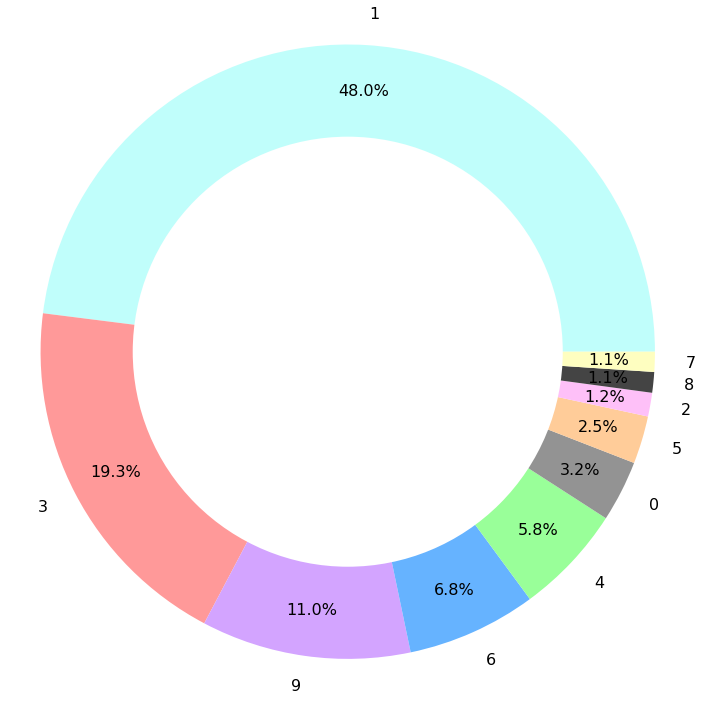

Most common 'victim_seating_position' for severity level of 'fatal' is '1'


'1'

In [304]:
colors = ['#C0FEFB', '#ff9999', '#D3A4FF', '#66b3ff', '#99ff99', '#939393','#ffcc99','#FEC0F8', '#444444', '#FEFEC0']
pie_chart(df, cs_labels[2], 'victim_seating_position', colors)

In [ ]:
max_collision = []
#colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#D3A4FF', '#939393', '#FEC0F8', '#FEFEC0']
max_collision.append(pie_chart(df, cs_labels[0], 'weather_1', colors))

34.860534470537054
36.597733100554066
38.47619892827561


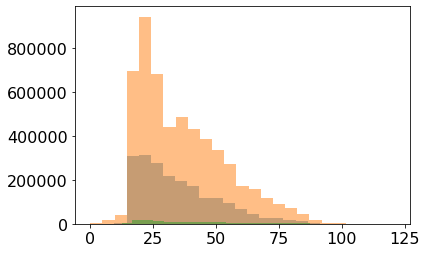

In [318]:
#pie_chart(df, cs_labels[0], 'party_age', colors)
spec_df = df[df['collision_severity'] == cs_labels[0]]['party_age']
plt.hist(spec_df, bins=25, alpha=0.5)
print(spec_df.mean())

spec_df = df[df['collision_severity'] == cs_labels[1]]['party_age']
plt.hist(spec_df, bins=25, alpha=0.5)
print(spec_df.mean())

spec_df = df[df['collision_severity'] == cs_labels[2]]['party_age']
plt.hist(spec_df, bins=25, alpha=0.5)
print(spec_df.mean())
#plt.vlines(df['party_age'].mean(), 0, 1.40e6)
#plt.ylim(0, 1.40e6)
#plt.title('At-fault age')
#plt.ylabel('frequency')
#plt.xlabel('age')
plt.show()

#labs = list(spec_df.value_counts().index.tolist())
#freqs = list(spec_df.value_counts())

25.11122806791277
32.993610090781694
36.796304748381424


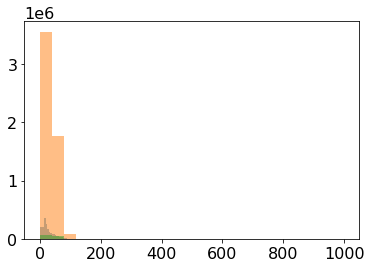

In [319]:
#pie_chart(df, cs_labels[0], 'party_age', colors)
spec_df = df[df['collision_severity'] == cs_labels[0]]['victim_age']
plt.hist(spec_df, bins=25, alpha=0.5)
print(spec_df.mean())

spec_df = df[df['collision_severity'] == cs_labels[1]]['victim_age']
plt.hist(spec_df, bins=25, alpha=0.5)
print(spec_df.mean())

spec_df = df[df['collision_severity'] == cs_labels[2]]['victim_age']
plt.hist(spec_df, bins=25, alpha=0.5)
print(spec_df.mean())

plt.show()